# Credit Card Fraud Detection - Regression vs. Ensemble

### Background	

**How Fraud detection system (FDS) works:**

<img src="https://drive.google.com/uc?id=1vm0zz1duQvQXA7VI6VARjNNkKWSu-WOT" width="800">


FDS consists of many layers four of them are automated, the first two layers are responsible for approving or denying transactions at source; once approved they are sent to additional filtering layers where suspicious ones gets flagged for further inspection by investigators. It’s important to know that approved transactions are already executed, an exchange has already happened, it’s now the responsibility of the additional filtering layers to flag them for damage control. We will be focusing on one of these additional layers being Data Driven Models for transaction classification.

**Controls in FDS:**

- Preventive (Blocking): happens as the transaction is being authenticated thus needs to be real time, most of transactions blocked by this type of control are fraudulent. An example would be physical usage of a credit card in a new geographical location that is not report by the user. That’s why almost all card issuers request the user to report a travel notice before using the card in destination country; otherwise it will most likely be blocked.


- Detective: happens after the transactions have been already authorized, all transactions are passed to a rule based model and a predictive model trained on historical usage patterns that is able to flag suspicious transactions for further investigation and intervention. Once suspicious transactions are flagged by the model they are sent to fraud investigators for validation. After validation the model is updated with investigation results in order to improve future predictions. Actions of investigators vary but usually entail direct contact with the registered card holder to confirm authenticity of flagged transactions.

**Credit Card Fraud can be:**

- Physical (Card present): Among popular methods are:
    1. Counterfeits: where card details are copied during a genuine transaction using bugged terminals (device that reads card data) then reproduced as genuine physical one.

    2. Lost/Stolen: self-explanatory, stealing can also happen at delivery of card to user.


- Card not present: represents majority of credit card fraud cases as it is easier to steal the necessary details needed to perform an online transaction than to steal the card itself. Three main credentials are needed to authorize an on-line transaction being 1) card number 2) expiry date and 3) CSC/CVV; these can be obtained using different methods some are complex such as database hacking others are relatively easy such as flipping physical card and memorizing the code during an exchange at a point of sale (POS) for example. That’s why it is advisable to hide CSC code at the back of the card to avoid being victim of such scheme.

**Detection challenges:**

- Classes are severely skewed (highly imbalanced) where the percentage of +ve class (fraudulent transactions) are usually below 1%
- Overlapping between classes, as we will see latter overlapping prevails even for the best discriminating features
- Huge volume of transactions, the dataset we will use is about 285k transactions for 2 days only.
- Maximizing detection can sometimes lead to increase in false alarms, as we will see later, thus Investigators may get overwhelmed by the amount of flagged transactions to validate.

This notebook discusses predictive modeling for classifying transaction either being fraudulent or not, using a highly imbalanced dataset (< 1% fraudulent transactions); several topics are going to be covered in a 'How Things Works' manner with examples.

<a id='toc'></a>
### Table of Contents
<ul>
<li><a href="#pca">Principal Components Analysis (PCA)</a></li>
<li><a href="#eda">Exploratory Data Analysis (EDA)</a></li>    
<li><a href="#pmb">Topics Covered</a></li>
<li><a href="#bcp">Binary Classification: Penalized Regression</a></li>
<li><a href="#lr">Logistic Regression</a></li>
<li><a href="#tm">Threshold Moving - Logistic Regression</a></li>
<li><a href="#pc">Probability Calibration - Logistic regression</a></li>
<li><a href="#ci">Addressing Class Imbalance</a></li>
<li><a href="#enp">Regularization Path - ElasticNet</a></li>
<li><a href="#ens">Ensemble Methods</a></li>
<li><a href="#rf">RandomForestClassifier</a></li>
<li><a href="#gb">GradientBoostingClassifier</a></li>
<li><a href="#cr">Conclusion and References</a></li>
</ul>

In [1]:
# import modules

import pandas as pd
import numpy as np
from time import time
from sklearn import datasets, linear_model, preprocessing, tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, auc, classification_report, confusion_matrix, accuracy_score, f1_score, brier_score_loss, \
r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from scipy.special import expit
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<a id='pca'></a>
### PCA illustrated

Most of the features (columns) in this dataset are principal components, thus it is important to understand principal components analysis (PCA). Nothing works better than a demonstration of the underlying concepts.

I'll be using Rock vs Mine dataset for illustration but I highly recommend that you go and watch [this](https://www.youtube.com/watch?v=FgakZw6K1QQ) and read [this](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues) before going through the below example. 

One more thing to note, in machine learning lingo what we use to make predictions are called (independent variables/features/attributes/predicators) and are usually denoted by X. What we try to predict is called (dependent variable/labels/class) and are denoted by y; for tabular data a table is called a matrix where X, y are the columns (usually y is the last column, others are X) and rows are samples of whatever the data represents.

About the Rock vs Mine dataset:

Rocks versus mines data are samples of acoustic signals from sonar taken at 60 different angels (and therefore 60 different frequencies); it’s a classification problem with the aim of properly classifying sonar frequencies as either being reflected off a rock or a mine so actions can be taken to address these unexploded mines.

n rows:  208 
 n cols:  61 
 ******************** 
 Explained variance ratio 
 [0.2  0.19 0.09 0.06 0.05 0.04 0.03 0.03 0.03 0.02 0.02 0.02 0.02 0.02
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.  ] 
 ********************


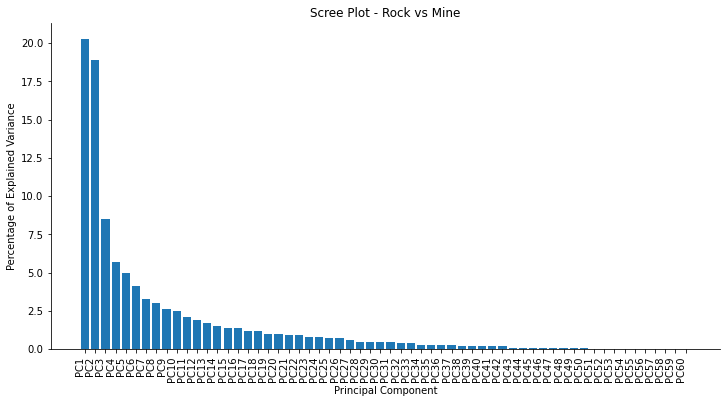

In [2]:
# PCA RvM

r_v_m = pd.read_csv('rock_vs_mine.csv')

# convert categorical target to numeric to work with linear models, 1.0 corresponding to mine, and 0.0 corresponding to rock
numeric_label = pd.get_dummies(r_v_m.V60)

# add new numeric variable, drop old and rename
r_v_m = pd.concat([r_v_m, numeric_label], axis = 1)
r_v_m.drop(['V60','R'], axis =1 , inplace = True)
r_v_m.rename(columns={'M':'label'}, inplace= True)
r_v_m.label = r_v_m.label.astype('float')

# separate features and labels
features = r_v_m.iloc[:,:60]
labels = r_v_m['label']

# scale and center, excluding target variable
r_v_m_scaled = preprocessing.scale(r_v_m.iloc[:,:60])

# fit and transform
pca_r_v_m = PCA(random_state = 45) # create a PCA object
pca_r_v_m.fit(r_v_m_scaled) # do the math
pca_data_r_v_m = pca_r_v_m.transform(r_v_m_scaled) # get PCA coordinates for scaled_data

# convert explained variance of each pc to a percentage
per_var = np.round(pca_r_v_m.explained_variance_ratio_* 100, decimals=1)

# construct names of each PC, i.e. PC1 PC2 etc...
labels_ = ['PC' + str(x) for x in range(1, len(per_var)+1)]

# PC dataframe
pca_df = pd.DataFrame(pca_data_r_v_m, columns=labels_)
 
print('n rows: ', r_v_m.shape[0], '\n',  'n cols: ', r_v_m.shape[1], '\n', '*'*20, '\n', 'Explained variance ratio', '\n',
        np.round(pca_r_v_m.explained_variance_ratio_, 2),  '\n', '*'*20)

# Scree Plot
fig, ax = plt.subplots(figsize=(12, 6))
    
plt.bar(x = range(1,len(per_var)+1), height = per_var, tick_label = labels_)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", fontsize = 10)
plt.title('Scree Plot - Rock vs Mine')
plt.gca().spines["top"].set_alpha(0.0); plt.gca().spines["right"].set_alpha(0.0);

In a nutshell, PCA is a dimensionality reduction technique. This sparks three main questions, answered in layman's terms:

1. What are dimensions?

    - Number of columns multiplied by rows is the dimensions of a given table. So, a table of 2 rows and 2 columns can be expressed as 2 x 2 matrix, 2 rows and 3 columns is a 2 x 3 matrix, 1 row and 4 columns is a 1 x 4 matrix and so on. You can plot(draw) a 2 x 2 matrix in a single plot, 1 dimension on x-axis and the other on y-axis (example: age and income), and maybe the 2 x 3 matrix but can't do more without having some sort of dimensionality reduction.
    
    - For a given table we can call rows as data points/samples and columns as dimensions that define the position of each sample in (n) dimensional space(where n is the number of columns in the table).


2. How it is done?

    - All features are grouped into n number of component called principal components (PC), n components must be = n features. **However**, and this is a key concept of PCA, any give principal component represents a mixture of original features **not** the original feature itself. If your first feature is age and you have 10 other features, PC1 is a mix of age and the 10 other features and does not represent age only.
    - Think of any PC as a food recipe that has several ingredients, these ingredients are mixed carefully to produce a tasty delicious PC!
    - These ingredients are called loading scores, will see that in a few.
    - These loading scores retain some meaningful properties of the original data.


3. Why?

    - Visualize 100+ dimensions in a 2D graph
    - Use PCs as an input for ML algorithm, as a sort of feature engineering and also reducing amount of features needed to train algorithm. This may improve performance and prediction results significantly

 
What is that plot above?

- Scree plot display how well each PC (mixture of features) reflects behavior of your data (interactions between features and how these relate to what we are trying to predict). Normally, first couple of PCs explains the data by 90%+, however, this is not the case in all datasets as we note here.

In [3]:
# Determine which attribute had the biggest influence on top three PCs
# We are accessing the ingredients of the recipe

# first, get the loading scores (mix of features - ingredients)
loading_scores = pd.DataFrame(pca_r_v_m.components_[0:3], columns=r_v_m.iloc[:,:60].columns)

# now sort the loading scores based on their magnitude, note that we are using absolute values to sort (ignoring sign)
sorted_loading_scores_PC1 = loading_scores.iloc[0].abs().sort_values(ascending=False)
sorted_loading_scores_PC2 = loading_scores.iloc[1].abs().sort_values(ascending=False)
sorted_loading_scores_PC3 = loading_scores.iloc[2].abs().sort_values(ascending=False)
 
# get the names of the top 10 attributes
top_10_attributes_PC1 = sorted_loading_scores_PC1[0:10].index.values
top_10_attributes_PC2 = sorted_loading_scores_PC2[0:10].index.values
top_10_attributes_PC3 = sorted_loading_scores_PC3[0:10].index.values

# print the attribute names and their scores
print("Top 10 attributes contributing to PC1: ", '\n'*2, loading_scores.iloc[0][top_10_attributes_PC1], '\n', '*'*100,  '\n', 
        "Top 10 attributes contributing to PC2: ", '\n'*2, loading_scores.iloc[1][top_10_attributes_PC2], '\n', '*'*100,  '\n', 
        "Top 10 attributes contributing to PC3: ", '\n'*2, loading_scores.iloc[2][top_10_attributes_PC3])

Top 10 attributes contributing to PC1:  

 V40    0.201924
V44    0.200815
V45    0.199261
V41    0.198204
V38    0.188787
V37    0.185057
V42    0.184619
V47    0.184091
V39    0.179848
V46    0.177100
Name: 0, dtype: float64 
 **************************************************************************************************** 
 Top 10 attributes contributing to PC2:  

 V15    0.238451
V14    0.237949
V13    0.231772
V16    0.222494
V18    0.216616
V17    0.213388
V19    0.209772
V20    0.187688
V28   -0.184511
V12    0.184297
Name: 1, dtype: float64 
 **************************************************************************************************** 
 Top 10 attributes contributing to PC3:  

 V26    0.239776
V27    0.233098
V25    0.226717
V46    0.226575
V35   -0.216069
V47    0.215222
V34   -0.214920
V48    0.207469
V24    0.205383
V36   -0.204157
Name: 2, dtype: float64


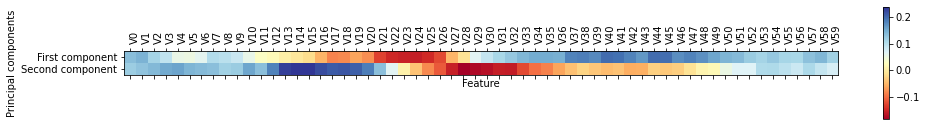

In [4]:
# visualize the loading scores (ingredients) using a heat map

plt.matshow(pca_r_v_m.components_[0:2, :], cmap='RdYlBu')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(r_v_m.iloc[:,:60].columns)), r_v_m.iloc[:,:60].columns, rotation=90, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components");

In [5]:
# Sample Xij

r_v_m.iloc[[0]]

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V51,V52,V53,V54,V55,V56,V57,V58,V59,label
0,0.02,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.018,0.0084,0.009,0.0032,0.0


I hope it’s clear now what was meant by **''any given principal component represents a mixture of original features not the original feature itself.''**

A downside of PCA is that each PC is often difficult to interpret. PCs correspond to directions in the original data, so they are combinations of the original features; these combinations are usually very complex to interpret. For the Rock vs. Mine problem, we know that V0 to V59 represents acoustic signals from sonar taken at different angels spanning 90 degrees for the cylinder (mine) and 180 degrees for the rock. Each pattern (row) is a set of 60 numbers where each value represents the energy within a particular frequency band, integrated over a certain period of time. 

Given the printed sample above, let Xij represent an X matrix (Table - 'r_v_m') of sonar signals with i rows (energy of a given frequency - 'index 0') and j columns (angels - V0, V1, etc...), X0V0 (0.02) represent energy of reflected signal frequency at angel V0, X0V1 (0.0371) is 2nd energy of reflected signal frequency at angel V1 and so on till all angels are fulfilled and a complete pattern (row) is obtained for a given object (either rock or mine - rock for the sample above)

Thus, we can *guess* which aspects of a sonar signal pattern each principal component is capturing by looking at the heat map. For example, the first component (PC1) seems to mostly capture behavior of frequencies for a combination of given angels (V21 to V25 and V37 to V48) ; the second component (PC2) is concerned with fluctuation in frequencies at different combination of angels (V13 to V20 and V28 to V32) and so on. 

These combinations *explains* , to some extent (loading scores), how original features affect change in class labels we are trying to predict; these interactions can be visualized in a 2D graph so we can get a slightly more complete picture of the problem at hand and ways to solve it.

Now that we know a little bit about PCA, let's use it!

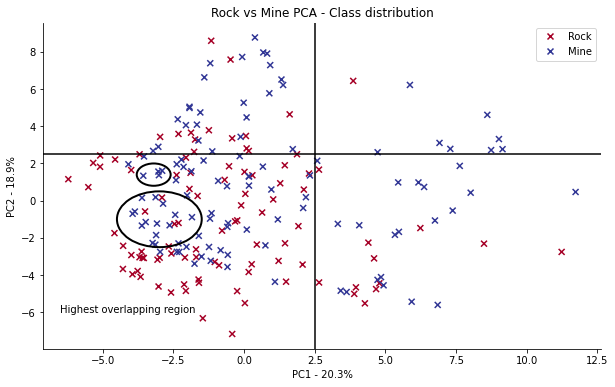

In [6]:
# visualizing Rock vs Mine dataset through PC1 and PC2

fig, axes = plt.subplots(figsize=(10, 6))
    
_ = plt.scatter(pca_df.PC1, pca_df.PC2, c =  r_v_m.label, marker='x', cmap = 'RdYlBu')

# # annotate each point by corresponding index to inspect original data
# for sample in pca_df.index:
#     plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))

# plt.colorbar(label = 'Rock or Mine')
# default decision threshold (cutoff)
plt.axhline(2.5, c="black", label="Cutoff")
plt.axvline(2.5, color="black", label="C = .01")
axes.add_artist(plt.Circle((-3, -1), 1.5, color = 'black', fill=False, linewidth = 2))
axes.add_artist(plt.Circle((-3.2, 1.4), 0.6, color = 'black', fill=False, linewidth = 2))
plt.text(-6.5, -6, 'Highest overlapping region')
plt.title('Rock vs Mine PCA - Class distribution')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))
plt.legend(handles = _.legend_elements()[0], labels = ['Rock', 'Mine'])
plt.gca().spines["top"].set_alpha(0.0); plt.gca().spines["right"].set_alpha(0.0);

Key observations from the above plot are:

 - We have spotted outliers! These 10 red markers to the left of the graph (right hand side beyond 2.5 x-axis value) worth further inspection, why are they present within clusters of mines?
 
 
 - Overlapping exist between classes at lower values (below 2.5 each axis) of PC1 and PC2, unlike the rest of the 3 quarters of the plot; compare number of red and blue markers. Data points within these ranges will be challenging for a classifier to correctly predict if only PC1 and PC2 are used.
 
 
 - Some clustering can be noted within the overlapping region (circled area), distance based classifier (i.e. KNN) would probably be a good choice for predicting class membership.
  
So we saw that doing PCA gave us some clues about class distribution, which data points would be challenging to classify and which classification method would best fit this problem.
 
PCA is awesome but has its limitations:
 - PCA assumes that the principle components are a linear combination of the original features. If this is not true, PCA will not give you sensible results.

- PCA uses variance as the measure of how important a particular dimension is. So, high variance axes are treated as principle components, while low variance axes are treated as noise. So basing our analysis and model on limited number of PCAs that do not represent much variance can be misleading.

We can look at another form of dimensionality reduction known as MDS - Multidimensional Scaling.

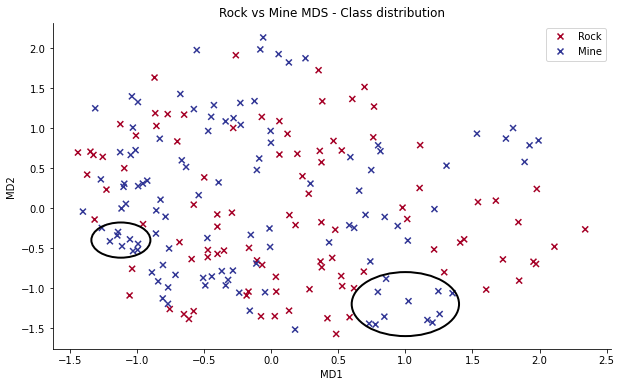

In [7]:
# MDS - Multidimensional Scaling

mds = MDS(random_state=45)
mds_data = mds.fit_transform(r_v_m.iloc[:,:60])

fig, axes = plt.subplots(figsize=(10, 6))

_=plt.scatter(mds_data[:, 0], mds_data[:, 1], c  = r_v_m.label, marker='x', cmap = 'RdYlBu')

axes.add_artist(plt.Circle((1, -1.2), .4, color = 'black', fill=False, linewidth = 2))
axes.add_artist(plt.Circle((-1.12, -0.4), 0.22, color = 'black', fill=False, linewidth = 2))
plt.legend(handles = _.legend_elements()[0], labels = ['Rock', 'Mine'])
plt.title('Rock vs Mine MDS - Class distribution')
plt.xlabel('MD1')
plt.ylabel('MD2 ')
plt.gca().spines["top"].set_alpha(0.0); plt.gca().spines["right"].set_alpha(0.0);

MDS is a technique used for analyzing similarity or dissimilarity data. It attempts to model similarity or dissimilarity as distances in a geometric spaces (distance between two points, aka the straight line distance.)

Same as noted from PCA plot above similar classes tends to be clustered together within specific ranges (examples are circled), distance based model would be a good choice for this dataset.

PCA vs MDS:

- PCA minimizes dimensions, preserving covariance of data. Covariance evaluates how the mean (average) values of two variables move together (**directional relationship**)
- MDS minimizes dimensions, preserving distance between data points.
- They are same, if covariance in data = [Euclidean distance](https://www.cuemath.com/euclidean-distance-formula/) between data points in high(original) dimension.
- They are different, if distance measure is different.
- Do not compare MDS with PCA plot as they have different calculations.

<li><a href="#toc">Table of contents</a></li>

<a id='eda'></a>
### Credit Card Fraud Detection - Exploratory Data Analysis

Enough about dimensionality reduction, back to the main project!

In [8]:
# Read Data

fraud = pd.read_csv('CC.csv', usecols= np.arange(1,  32))

# copy to work on
fraud_df = fraud.copy()

fraud_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Time and Amount are the only original variables available to us, rest are scaled principal components.

In [9]:
# shape (dimensions) and class distribution

print('n rows: ', fraud_df.shape[0], '\n',  'n cols: ', fraud_df.shape[1], '\n', '*'*20, '\n', 'Ligitimate transactions (-ve class): ', 
        fraud_df.Class.value_counts(normalize = True)[0].round(4), '\n',  'Fraudulent transactions (+ve class): ', 
        fraud_df.Class.value_counts(normalize = True)[1].round(4))

n rows:  284807 
 n cols:  31 
 ******************** 
 Ligitimate transactions (-ve class):  0.9983 
 Fraudulent transactions (+ve class):  0.0017


Sever class imbalance where +ve class represent only 0.17% of total population

In [10]:
# statistical summary

fraud_df.describe().round(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


In [11]:
# sampling for plots as we can consider -ve class (legitimate transactions) a redundant data so it will crowd plots with no added value, also 
# it is computationally expensive to generate some of the upcoming plots with full data rows

# Scaling Time and Amount variables
fraud_df.Time, fraud_df.Amount = preprocessing.scale(fraud_df.Time) , preprocessing.scale(fraud_df.Amount)

# Separate fraudulent from legitimate transactions
f_tr = fraud_df[fraud_df.Class > 0]

n_tr = fraud_df[fraud_df.Class == 0]

# Sample dataframe including all fraudulent transactions and sample of legitimate ones 
f_tr_ = f_tr.append(n_tr.sample(3000, random_state = 45))

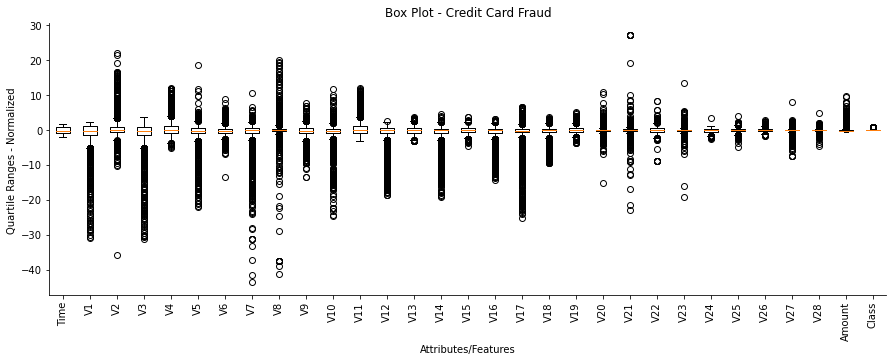

In [12]:
# box plot

fig = plt.subplots(figsize=(15, 5))

plt.boxplot(f_tr_.values)
plt.xticks(range(1, len(f_tr_.columns) +1 ), labels = f_tr_.columns, rotation = 90)
plt.title('Box Plot - Credit Card Fraud')
plt.xlabel("Attributes/Features")
plt.ylabel(("Quartile Ranges - Normalized "))
plt.gca().spines["top"].set_alpha(0.0); plt.gca().spines["right"].set_alpha(0.0);

Box plot is the visualization of the statistical summary printed above, box edges represents Q2(25% percentile) and Q3(75% percentile) while the line in the middle of the box is the median (50% percentile). The whiskers(vertical lines) above and below the box represents the max and min points for each attribute column, they extend to max of 1.5 * IQR(Interquartile range that is Q3 - Q2) or max/min range whichever is less; any point above that is considered an outlier and is represented by a circle.

Each box depicts the distribution of data for each attribute, we can observe that V1 is -vely skewed (left tailed). However, the boxes are not well observed given that the IQR values are so small, histograms will provide better display. 

The data is standardized (centered), this means that values of each column are scaled to have average/mean of 0 and a unit variance. That’s why you can note that all boxes are aligned horizontally at 0 on the y-axis. Notice that standardization does not mean that all values fit between -1 and 1, it’s more or less placing the lower and upper edges of the boxes at -1 and 1, but much of the data are outside these boundaries. For example the distance to the grocery store can be 1 if measured in miles or 5,280 if measured in feet, these different scales won't construct a meaningful plot and standardization fixes that.

Standardization is also important to a number of algorithms that are distance based. For example, K‐means clustering builds clusters based on vector distance between rows of data. Distance is measured by subtracting one point from another and squaring. If the units are different, the numeric distances are different.

The box plot of the Fraud dataset attributes shows a remarkable number of outliers (black circles). Key driver of such outlier behavior is the unbalanced nature of the dataset as it is highly skewed towards -ve class (legitimate/non-fraudulent transactions).

This radical behavior can be a good thing for distinguishing classes from one another, but it also means that the method (model) for making predictions has to be able to trace a fairly complicated boundary between the different classes. Ensemble models will produce more complicated decision boundaries than penalized linear regression if they are given enough data. 

Next step is to understand how such variation affect class membership, how shall we deal with all these outliers?

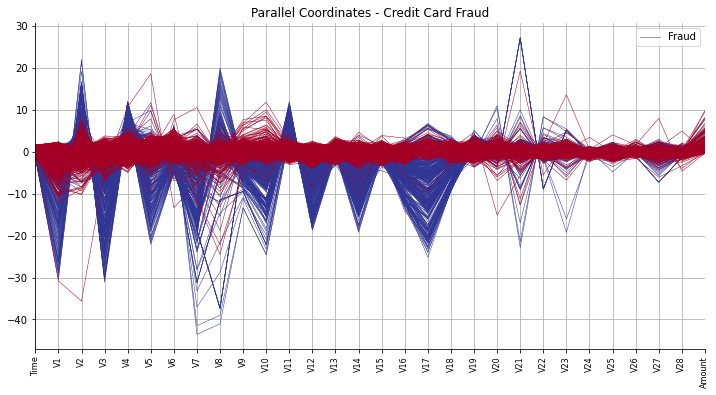

In [46]:
# Parallel Coordinates plot

fig, ax  = plt.subplots(figsize=(12, 6))

pd.plotting.parallel_coordinates(f_tr_, 'Class', linewidth=0.5, colormap = 'RdYlBu_r', axvlines=False)

plt.setp(ax.get_xticklabels(), rotation=90, ha="center", fontsize = 8)
plt.title('Parallel Coordinates - Credit Card Fraud')
plt.legend(['Fraud'])
plt.gca().spines["top"].set_alpha(0.0); plt.gca().spines["right"].set_alpha(0.0);

# fig.savefig('par_cords.svg', format = 'svg', dpi=1200)

The parallel coordinates plot casts all rows in the underlying dataframe (table/X matrix) to a graph colored according to the corresponding class, here we have two classes only either a fraudulent transaction (blue color) or not/legitimate ones (red color); along the x axis are the attributes (features). The overall aim of this plot is to visualize class discrimination along the feature space and identify systematic relationships between attribute values and class labels.

As mentioned earlier, apart from time and amount features, all other features are principal components (PCs) that are usually sorted in a descending order according to their explained variance ratios (the higher the better); that’s why we can note that class discrimination is highest among some features of V1 to V18 (**V17 signifies such relationship**) and slowly fades away starting from V19. Note that legitimate transactions in this plot are selected on a random sample basis; this is to enable us to visualize the data clearly given that fraud transactions are only 0.17% of total population. The predictive models will rank attributes on the basis of their importance in generating predictions, these visual observations will be supported by the predictive models later.

We can note that the distribution of non-fraud transactions (red lines) is centered on zero, with few outliers. Unlike the blue lines (fraudulent transactions) that are at the edges of the data for several attributes—in other words, they are outliers along these attributes. So, mostly box plots outliers are fraudulent transactions! We'll explore this later using a series of different plots.

The above plot also indicates correlation (+ve / -ve) between some of the attributes and the type of transaction/class membership. For example, we can note that fraudulent transactions increase with decreased values of V1 and increased values of V2. However, given the existence of some overlapping between colors (V8 and V27 as an example) the strength of correlation will be better indicated by the correlation matrix plot. Such overlapping, suggests that those features might not be enough to correctly predict the labels.

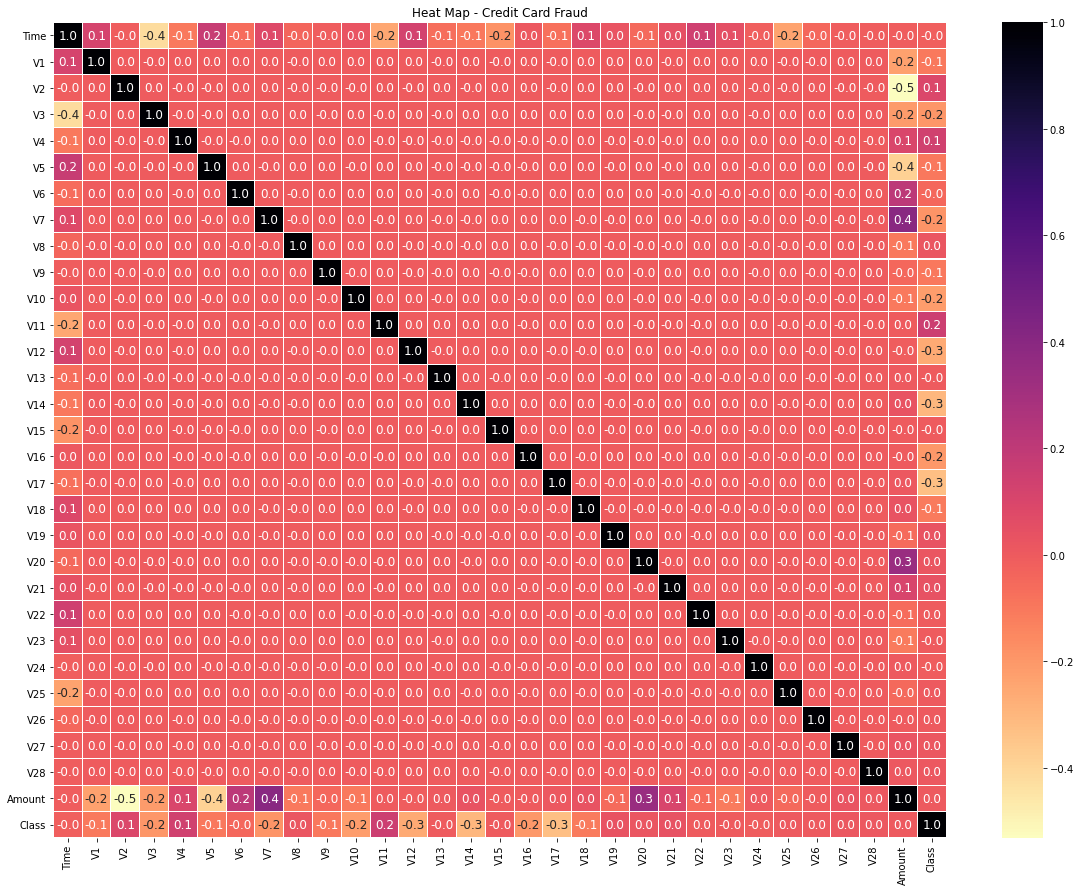

In [14]:
# calculate correlations between real-valued attributes
corMat = pd.DataFrame(fraud_df.corr())

#visualize correlations using heat map
fig = plt.subplots(figsize=(20, 15))

sns.heatmap(corMat, cmap = 'magma_r', annot = True, fmt ='.1f', linewidths = .03, annot_kws={"size":12})
plt.title('Heat Map - Credit Card Fraud');

Heat maps helps in confirming observations noted in parallel coordinates plot with an added advantage of quantifying the strength of correlation between attributes together and with the target/labels/class.

We can note that V1 to V18 are correlated with the classes with varying degree of strength and direction, starting from V19 no/minor correlation is observed. This suggests that class discrimination may be higher along these correlated features than others but does not guarantee this as we will see later.

Another important thing to note here is the absence of correlation between principal components (V1 to V28), this is one of the benefits of principal component analysis as each principal component is independent from one another.

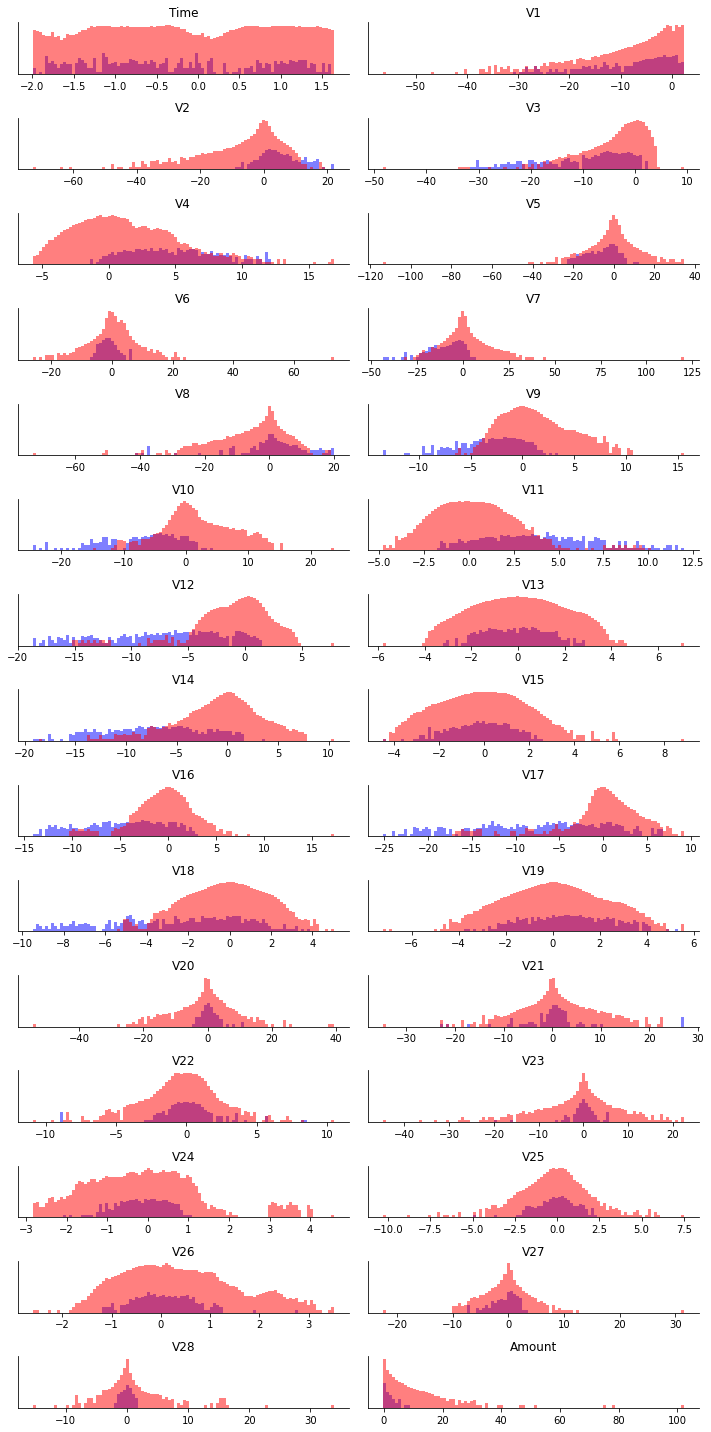

In [15]:
# Fraud distribution across features

fig, axes = plt.subplots(15, 2, figsize=(10, 20))
ax = axes.ravel()

for i in range(30):
    _, bins = np.histogram(fraud_df.iloc[:, i], bins = 100)
    ax[i].hist(f_tr.iloc[:, i], bins = bins, color='b', alpha=.5)
    ax[i].hist(n_tr.iloc[:, i], bins = bins, color='r', alpha=.5)
    ax[i].set_title(fraud_df.columns[i])
    ax[i].set_yscale('log')
    ax[i].set_yticks(())
    ax[i].spines["top"].set_alpha(0.0); ax[i].spines["right"].set_alpha(0.0);

fig.tight_layout();

Histograms represent counts (y-axis) of how often a data point appears in a certain range (x-axis bins). Each plot overlays two histograms, one for all data points (rows) of fraudulent class (blue) the other is for the legitimate class (red). 

This gives us an idea of how classes are distributed across features, and allows us to guess which feature(s) are better at distinguishing fraudulent from legitimate transactions. For example features 'V10', 'V11', 'V12', 'V14', 'V16', 'V17' seems quite informative because the histograms are quite disjoint, unlike features 'Time, 'V1', 'V5', 'V6' as the two histograms mostly overlap.

All previous visual observations are emphasized here; we can observe that fraudulent transactions' Amount is asymmetric (skewed distribution). Amount histogram is right skewed distribution/positive skew distribution, that’s because the tail is longer on the positive direction of the number line and indicate that values of fraudulent transactions are less than that of the legitimate ones; also less transactions are occurring at the end of the tail indicating that majority of fraudulent transactions are of lower values. Luckily, the extreme outlier transactions are legitimate ones!  

However, this plot doesn’t show us anything about the interactions between variables and how these relate to class membership. Which we will explore next using selected features to understand how mixing features can affect prediction results.

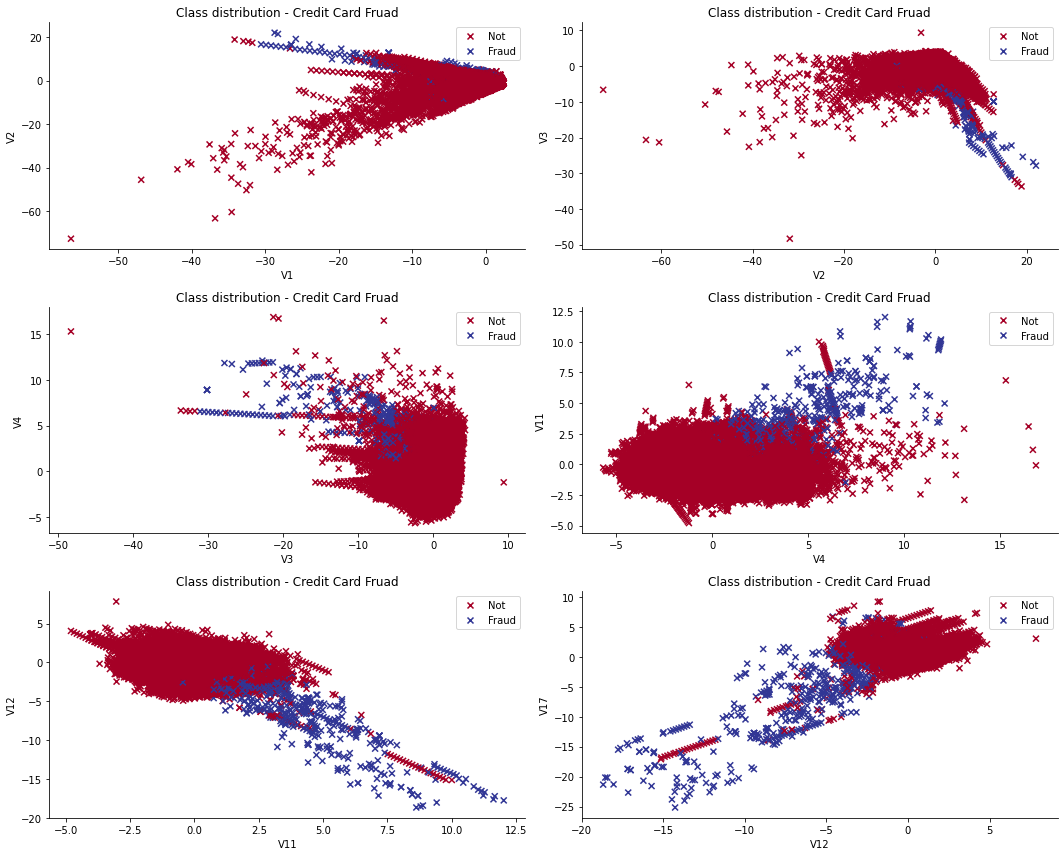

In [16]:
# Class distribution over different combination of features

plt.subplots(figsize=(15, 12))

feat_plot = ['V1', 'V2', 'V3', 'V4', 'V11', 'V12', 'V17']

for i in range(len(feat_plot)):
    if i != 6:                        # 6 is last item in 0 indexed list (V17), we don’t want to plot it as it is already ploted with index 5 (V12)
        plt.subplot(3,2,i+1)
        plt.tight_layout()
        _ = plt.scatter(fraud_df[feat_plot[i]], fraud_df[feat_plot[i+1]], c = fraud_df.Class, marker='x', cmap = 'RdYlBu')
        plt.title('Class distribution - Credit Card Fruad')
        plt.xlabel(feat_plot[i])
        plt.ylabel(feat_plot[i+1])
        plt.legend(handles = _.legend_elements()[0], labels = ['Not', 'Fraud'])
        plt.gca().spines["top"].set_alpha(0.0); plt.gca().spines["right"].set_alpha(0.0);
    else:
        break

Going through several combination of features we can note that class discrimination gets more challenging as we include features that have somewhat similar frequency distribution (for example: V1 and V5), unlike mixing features that have disjoint frequency distribution (for example: V4-V11, V11-V12 and V12-V17) which result in better clustering of classes and maybe prediction results. This behavior can be captured from above plots, notice how fraudulent transactions gets clustered away from legitimate ones as we move towards the last plot. 

Note that these are all PCs so we are switching view angle of all data points at each plot using a mixture of original features, each plot provides a visual representation of how the data would look like given this mix.

This emphasize the importance of feature selection and how it could affect prediction results, Imagine drawing a line (as a decision boundary) to separate blue and red dots, which plot would result in best separation among those presented above?

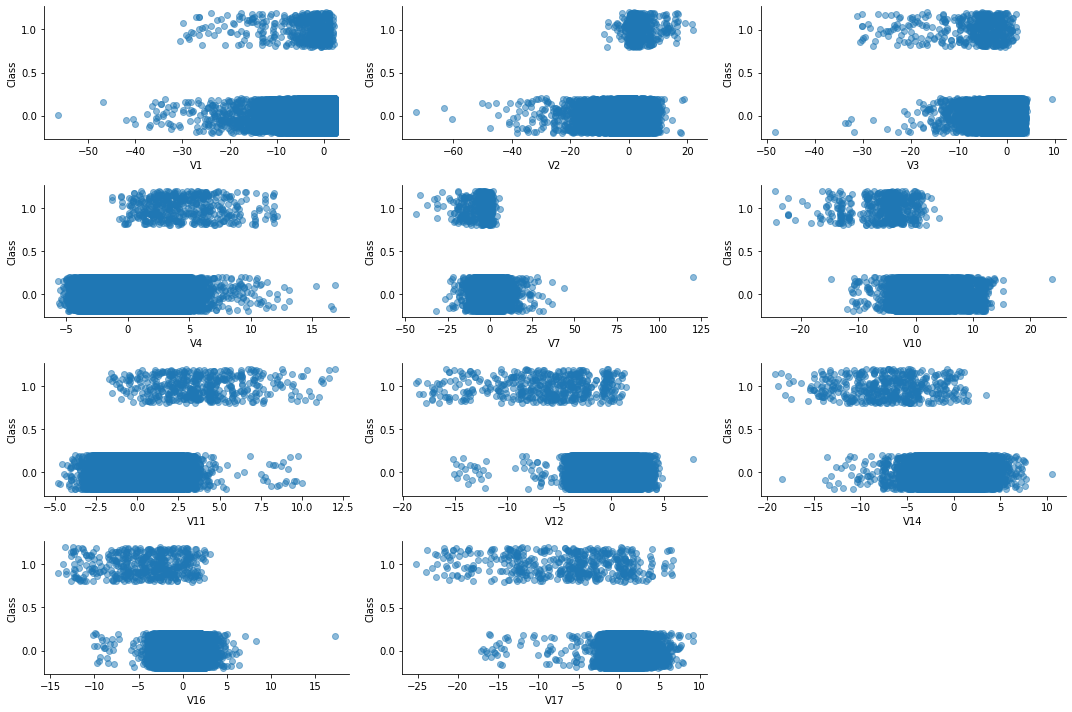

In [17]:
# plot selected attributes vs classes

attr_list = ['V1', 'V2', 'V3', 'V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17']

plt.subplots(figsize=(15, 10))

for i, v  in enumerate(attr_list):
    plt.subplot(4,3,i+1)
    plt.tight_layout()
    sns.regplot(x = fraud_df[v], y = fraud_df.Class, fit_reg= False, y_jitter= 0.2, scatter_kws={'alpha': 0.5})
    plt.gca().spines["top"].set_alpha(0.0); plt.gca().spines["right"].set_alpha(0.0);

Some variables perform as expected in separating classes i.e.: V10 to V17, we can notice how dotted lines are separated on the plots with some fairly decent concentration (darker dots) at separation points. However, overlapping between classes is prevailing.

<li><a href="#toc">Table of contents</a></li>

<a id='pmb'></a>
### Predictive model building:

In the following sections, we'll evaluate different models and assess the impact of introducing some adjustments on prediction results, the following will be covered:

- How models make predictions, linking visual observations to model behavior on fitted data
- Best metric to use when evaluating models and how some metrics can be misleading
- Assessment of costs associated with prediction errors
- Factors influencing selection of classification thresholds, why optimal thresholds may not be best to use at model deployment
- Threshold moving impact on prediction results and total cost of misclassification errors
- Probability calibration: why and how to?
- Methods for handling class imbalance issue
- Feature importance, intuition vs. model behavior
- Penalized linear models vs. Ensembles

We will be following a hands-on (applied) approach, just like the PCA illustration earlier, with minimum jargon and fancy mathematics. If you want the latter, I’ll leave a list of references for you at the end of this notebook.

All models will be used at default parameters, with minor adjustments to illustrate a concept. The context of this notebook is to explore the above topics using different classification models rather than seeking an optimized one.

The next 4 cells support the narrative that follows, skip if you are already familiar with these concepts. That narrative is the longest in this notebook but lays foundations for topics that will be explored ahead.

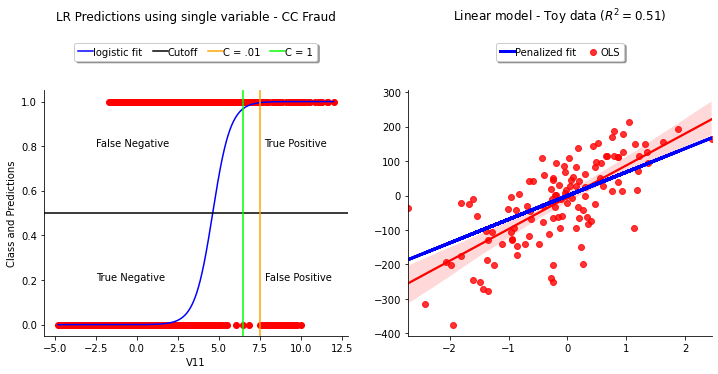

In [18]:
# Logistic and Linear regression visualization plots - to be used along with narrative below.

# Logistic regression

# selected feature for training model and visualizing results
feature_logistic = fraud_df.V11

# Plot feature
fig  = plt.subplots(figsize=(10, 4))
plt.tight_layout()

plt.subplot(1, 2, 1)

plt.scatter(feature_logistic, fraud_df.Class, c = 'r')

# Fit
lr_clf = linear_model.LogisticRegression(C = 1, random_state=45)
lr_clf.fit(feature_logistic.values.reshape(-1,1), fraud_df.Class)

# test set for drawing sigmoid curve
x_test = np.linspace(feature_logistic.min(), feature_logistic.max(), fraud_df.shape[0]).reshape(-1,1)

# plot sigmoid curve
plt.plot(x_test, lr_clf.predict_proba(x_test)[:,1], c = "b", label = "logistic fit")

# default decision threshold (cutoff)
plt.axhline(.5, c="black", label="Cutoff")
 
# shifting sigmoid curve following changes in regularization parameter C
plt.axvline(7.5, color="orange", label="C = .01")
plt.axvline(6.5, color="lime", label="C = 1")
 
# decoration
plt.text(7.8, 0.8, 'True Positive')
plt.text(-2.5, 0.8, 'False Negative')
plt.text(-2.5, 0.2, 'True Negative')
plt.text(7.8, 0.2, 'False Positive')
plt.xlabel('V11')
plt.ylabel('Class and Predictions')
plt.title("LR Predictions using single variable - CC Fraud", pad = 70)
plt.legend(ncol=4, loc=8,  bbox_to_anchor=[0.5, 1.1],  columnspacing=1.0, labelspacing=0.0, handletextpad=0.0, handlelength=1.5,
                fancybox=True, shadow=True)
plt.gca().spines["top"].set_alpha(0.0); plt.gca().spines["right"].set_alpha(0.0);

plt.subplot(1, 2, 2)

# linear model

# toy regression data
x, y = datasets.make_regression(n_samples=600, n_features=1, noise=100, n_informative=1, random_state=45)

# split for modeling
x_train, x_test, y_train, y_test = train_test_split(x.reshape(-1,1), y.reshape(-1,1), test_size=0.2, random_state = 45)

# linear regression model
regr = linear_model.LinearRegression()

# train
regr.fit(x_train, y_train)

# predictions
y_pred = regr.predict(x_test)

# plot regression dataset
sns.regplot(x = x_test, y = y_test, color = 'r', label='OLS')
plt.plot(x_test, y_pred / 1.3, color="blue", label = 'Penalized fit', linewidth=3)
plt.title("Linear model - Toy data ($R^2= %.2f$)" %  r2_score(y_test, y_pred).round(2), pad = 70)
plt.legend(ncol=2, loc=8,  bbox_to_anchor=[0.5, 1.1],  columnspacing=1.0, labelspacing=0.0, handletextpad=0.0, handlelength=1.5,
                fancybox=True, shadow=True)
plt.gca().spines["top"].set_alpha(0.0); plt.gca().spines["right"].set_alpha(0.0);

In [19]:
# analyzing OLS of toy dataset, using stats model

# adding intercept
x_ = sm.add_constant(x_test)

# train model and print results
lm = sm.OLS(y_test, x_)

results = lm.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     122.4
Date:                Mon, 20 Dec 2021   Prob (F-statistic):           6.00e-20
Time:                        01:24:13   Log-Likelihood:                -703.53
No. Observations:                 120   AIC:                             1411.
Df Residuals:                     118   BIC:                             1417.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.6439      7.937     -0.585      0.560     -20.361      11.074
x1            92.5242      8.364     11.062      0.000      75.961     109.088
==============================================================================
Omnibus:                        3.453   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.178   Jarque-Bera (JB):                3.055
Skew:                          -0.386   Prob(JB):                        0.217
Kurtosis:                       3.117   Cond. No.                         1.19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
# MSE, Variance and R squared

print('Mean Squared error - MSE - (aka ss(fit)):', f'{int(mean_squared_error(y_test, y_pred)):,}', '\n', '*'*100, '\n', 
        'Variance - (aka ss(mean)):', f'{int(np.var(y_test).round()):,}', '\n', '*'*100, '\n', 
        'R - Squared / Coefficient of determination:', ((np.var(y_test) - mean_squared_error(y_test, y_pred)) /  np.var(y_test)).round(2))

Mean Squared error - MSE - (aka ss(fit)): 7,272 
 **************************************************************************************************** 
 Variance - (aka ss(mean)): 14,751 
 **************************************************************************************************** 
 R - Squared / Coefficient of determination: 0.51


In [21]:
# Logistic Regression real valued predictions to probabilities

# predictions using Logistic Regression equation
y_hat = lr_clf.intercept_ + x_test * lr_clf.coef_ 

# Mapping real valued predictions to probabilities
sigmoid = expit(y_hat)

# Sigmoid vs predict_proba method for +ve class
print('Real valued predictions', '\n'*2, y_hat[:3].round(4), '\n', '*'*100, '\n',
        'Sigmoid function:', '\n'*2, sigmoid[:3].round(4), '\n', '*'*100, '\n', 
        'Predict_proba method:', '\n'*2, lr_clf.predict_proba(x_test)[:,1].round(4).reshape(-1,1)[:3])

Real valued predictions 

 [[-8.2595]
 [-9.3057]
 [-6.3465]] 
 **************************************************************************************************** 
 Sigmoid function: 

 [[0.0003]
 [0.0001]
 [0.0017]] 
 **************************************************************************************************** 
 Predict_proba method: 

 [[0.0003]
 [0.0001]
 [0.0017]]


<a id='bcp'></a>
## Binary Classification: Penalized Regression

### Setting the scene:

**Essene of Supervised machine learning (function approximation problems)**

Supervised machine learning problems is one type of machine learning problems where we use historical data with a known outcome to predict the outcome of new unknown/unseen data. These type of problems have two main pillars being independent variables (aka: attributes/variables/features/predictor) and dependent variables (aka: outcome/labels/class); it is called function approximation because the goal is to build a model that generate predictions of the dependent variable as a function of the independent variables.

Several methods are used to come up with such predictions we focus here on two of them that have broad applications:
- Linear models
- Ensembles

**Linear Models:**

**Linear Regression (aka Ordinary Least Squares - OLS):**

Use the right hand side plot in conjunction with the below narrative.

OLS produce solution (predictions) to a given problem (estimating house prices for example) by fitting a line through the data, can’t get simpler than this!

A typical linear regression equation of population parameters for a regression line using a single feature would be *y = a + bx* , where:
- y: prediction (aka dependent variable)
- a: intercept, the point where the line crosses y-axis. It’s simply the location on the line on y-axis (-250 for red line in the above plot)
- b: slope(coefficient), it is the estimation of how much a given feature affect the change in y
- x: any given feature(independent variable), size of house for example when used to estimate its price

In order to build intuition, we can think of a typical fitting iteration (steps taken towards problem solution) as follows:
- draw a line through the data, a horizontal line for example as a start.
- Measure the distance between each data point and line (aka residuals)
- Square the value of each distance, squaring ensure that -ve variances do not cancel out +ve ones
- Sum the squared distances (residuals) for this given line (aka Residual Sum of Squares -RSS). This is usually called the objective function (aka cost function) to be minimized by the linear model; distance is the difference between the actual point (any red point in the scatter plot) and the corresponding location on the fitted line (which represent the model's prediction for that point). We are here simply calculating actual - predicted value for all data point (samples) of the attribute(s) being modeled
- rotate the line and repeat the above steps

The above steps produce a linear equation for each line in the iterations; the line that has the lease squared residuals/errors/distances/RSS is considered to be the best fitted line. Hence the name, Ordinary least squares.

We will assume that the toy data represent house price (dependent variable y) and size (independent variable x) Assuming a linear relationship exists between a house price (y-axis) and size (x-axis), The red line is the OLS solution for predicting house price based on a single feature being house size (line that produced least squared errors from all the lines in the solution iteration).

**What does the *line* represent?**

Predictions based on set of variables. Imagine the above OLS plot with only the red line drawn and that you found a house that you like with a given size of x. All you need to do next is to locate the y amount that corresponds to that size of x, which will be the estimated house price. So by modeling historical data of house prices with different sizes, you can now decide if the house that you are interested in does really worth the stated price **given** the current size of the house assuming that size is the only factor affecting house price.

**How are coefficients (slops) calculated?**

One way to do it is to divide the covariance by the variance of x (independent variable), so in a single linear equation of y = a +bx; b is = covariance / variance(x) where covariance is = Sum ((x - xmean) * (y - ymean)) / n - 1 for un-normalized values.

**How confident should one be in the solution (estimated price)?**

Several tests can be performed to answer this question some are discussed below; but before we do so let’s look at some essential terminology for understanding these tests:

- Variance:
    - Is the average of the squared deviations from the mean. It represent how far each point is from the mean (average) in squared terms, squaring ensure that -ve values don't cancel out +ve ones

- Null hypothesis:
    - An assumption you are trying to nullify; example (House size does not affect price)

- Alternative hypothesis:
    - An assumption you are trying to prove; example (House size does affect price)

- Statistical significance tests:
    - Different measures that help us determine which of the hypothesis are true. Do we accept the null hypothesis (fail to reject null hypothesis) or we reject it based on results of tests we performed. 
    - For any of the variables that are included in a regression model, the null hypothesis is that the coefficient is equal to 0 (i.e.: the attribute has no effect on prediction). The alternative hypothesis is the opposite (i.e.: the attribute does affect predictions). We would like to know whether the coefficients calculated by the regression model are really obtained from population where the null hypothesis is true or not, so we run some tests and based on results we conclude whether these results are statistically significant to support the alternative hypothesis or are just due to random chances; If the former then we can decide to reject the null hypothesis and rely on regression results for predictions.
 

**T test**

t = (coef/std err). I.e. *t* of x coef in the toy dataset is: t = (92.5242 / 8.364) = 11.062

*t* represents the number of std deviations the estimated coef is away from 0 in a standard normal distribution curve(the famous bell shaped curve that is centered at zero and 1 std), A  high *t* statistic signals high significance of calculated coefficient in deciding whether to reject the null hypothesis or not(thus concluding that this attribute has an effect on predictions); since that x coef is 11 std deviations away from the mean of a normal distribution curve(i.e.: it is outside of the curve) so we can be more confident in concluding that this calculated statistic(coef) came from a population different than that of the null hypothesis; thus we can accept the alternative hypothesis that suggests that this attribute does affect predictions.

Confusing?! Change the value of noise in the toy dataset from 100 to 10, rerun the cell displaying stats model results and note the effect on std err value, R squared and *t* test. You will note that all have increased values highlighting how good is the variable x at predicting y which can be observed from the regression line plot, the line fits the data so well.

Think of *t* test as a measurement of the precision with which the coefficient was measured, the higher the better.

**P value**

*P* is the opposite of *t* test, as it is the probability that the observed statistic came from the same distribution of the null hypothesis; thus, the higher the worse. What we mean by worse here is that as the probability increase we get more confident that the observed statistic supports the null hypothesis; so for high *P* we accept the null hypothesis (fail to reject null) and can be **some what** confident in concluding that the attribute does not affect prediction.

For the toy dataset, *P* of 0 confirms high value of *t* test and both are confirmed by R squared as 51% of variance is explained by this single attribute.

What threshold determines a high/low *P*? A common threshold of 0.05 is widely used for 2 tailed tests, so 0.25 for a one tailed test. No need to bother with what is a one/two tailed test now. Low *P* (< 0.05) indicates that you can reject the null hypothesis. In other words, an attribute that has a low *P* is likely to be a meaningful addition to your model because changes in the attribute's value are related to changes in the dependent variable. Conversely, larger *P* suggests that changes in the attribute are not associated with changes in the dependent variable.

In short, *P* is a measure of how likely the observed (sample) statistic (mean, variance, coef, etc...) is likely to be obtained from a population where the null hypothesis is true. It is calculated by adding up the following probabilities (using normal coin flip as an example):

- Probability of random outcome of the observed statistic (example: probability of obtaining 2 heads when flipping normal coin 2 times is = .025)
- Probability of similar outcome that is equally rare (example: probability of obtaining 2 tails when flipping normal coin 2 times is = .025)
- Probability of extreme/additional rare event (example: probability of obtaining a rare event other than 2 heads/tails = 0 as it is either 2 heads/tails or 1 heads 1 tails)
- P = 0.25 + 0.25 + 0 = 0.5.

Null hypothesis for the above example would be that the flipped coin is not different from any other coin, where the alternative hypothesis would be that the coin is special; High *P* of 0.5(> 0.05) confirms the null hypothesis that this coin came from a population of regular coins thus we would fail to reject the null (aka accept null hypothesis).

**R squared**

Is the percentage of variation around the mean (aka variance) that goes away (can be reduced) as a result of linear regression equation, in other words it’s a measure of how good the regression is at explaining the variance in the data set which help us determine how good the model is and how good is it compared to other models.

Adjusted R-squared is important for analyzing multiple dependent variables’ efficacy on the model. The adjusted R-squared penalizes the R-squared formula based on the number of variables; therefore a lower adjusted score may be telling you some variables are not contributing to your model’s R-squared properly.

For the toy dataset we can say that 'Approximately 51% of the variance in house prices is explained by their size'.

**An important thing to note is that all the above tests need to be taken with a pinch of salt, below are limitation of both metrics:**

*P:*

One thing to note that P does indicate the significance (or not) of the calculated statistic (coef in our example) in respect to the null hypothesis (coef = 0) but does not indicate that this attribute will have a significant impact on model performance just because of being significant or not to the null hypothesis i.e. having a non-zero coef.

"Correlation does not imply causation." In other words, while correlations may sometimes provide valuable clues in uncovering causal relationships among variables, a non-zero estimated correlation between two variables is not, on its own, evidence that changing the value of one variable would result in changes in the values of other variables. For example, the practice of carrying matches (or a lighter) is correlated with incidence of lung cancer, but carrying matches does not cause cancer (in the standard sense of "cause").

In short, do not relate attributes with low P to how a model will perform, it is just for guidance.

*R squared (R2):*

R2 does not indicate whether:

- The independent variables are a cause of the changes in the dependent variable;
- The correct regression was used;
- The most appropriate set of independent variables has been chosen;
- There is collinearity between explanatory variables (correlation between attributes);
- The model might be improved by using transformed versions of the existing set of independent variables;
- There are enough data points to make a solid conclusion.

We've discussed so far linear model for a single feature, same concepts applies to one with several features. The equation is expanded to account for the increase in the number of features as y = a+ b1x1 + b2x2 + b3x3; where x1/x2/x3 corresponds to the number of features and b1/b2/b3 are the corresponding coefs. 

**Logistic Regression (LR):**

Use the left hand side plot in conjunction with the below narrative.

It is a special type of linear regression where the dependent variable is categorical in nature (Yes/No, Fraud/Not). Instead of fitting a line, LR fits an S-shaped logistic function (sigmoid function) which goes from 0 to 1 and it basically predicts the probability of class membership of different data points so the objective is to maximize Maximum Likelihood Estimation (MLE) unlike linear regression that seeks minimizing least square errors

A proper S shaped curve would have few points that extend beyond the tip of the S curve (most points are on the straight line that extend along the 0 and 1 y axis), in the given example we are using a single feature that is fairly good at separating fraudulent transactions from legitimate ones, that’s why we can note that lots of point extend beyond the edges of the S shaped curve.

LR make predictions by estimating the probability of a given data point to be either a member of 0 (-ve class) or 1(+ve class) according to a default threshold which is located exactly at 0.5 on y axis in the plot above. Any sample that has a probability > 50% will be classified as a positive class; else is -ve. 

So the default probability(threshold) for predicting class labels is 50%, which can be manually adjusted using different thresholds that we believe would provide better predictions for underlying problem. This process of selecting different classification probability (threshold) is called *Threshold Moving*, which will be discussed in details later.

**Important terminology to understand how LR model work:**

Assuming we have 5 transactions in total of which 2 are fraudulent

*Probability:*

Something happening to all possible things that could happen. Example, the probability (P) of fraudulent transaction are 2 to 5 = 2/5 = 0.4, where something happening is denoted by the instance of fraudulent transactions of 2 and something not happening is denoted by all transactions of 5
 
*odds (likelihood):*

Something happening to something not happening. Example: the odds of fraudulent transactions are 2 to 3 = 2/3 = .67, where something happening is denoted by the instance of fraudulent transactions of 2 and something not happening is denoted by non-fraudulent transactions of 3

Calculating odds from probability:

P (fraud) = 2/5 = 0.4
P (no fraud) = 3/5 = 0.6

odds fraud =  (P / 1 - P) = 0.4 / 1 - 0.4 = 0.67

Log(odds) = log(0.67) = -0.40

odds can have widely varying scales that’s why we use log(odds) to shrink scales to a similar magnitude. Log(odds) is one of the main functions of logistic regression as we will see next.

**How coef and Maximum Likelihood Estimation - MLE are computed in logistic regression (LR)?**

LR has two main functions:

- logit(aka log(odds), aka Logit Link) = log(P / 1 - P) where P is probability values ranging between 0 and 1 on the y-axis

- sigmoid(expit in statsmodels) = 1 / (1+ exp(-logit))

Since Y axis (class/labels) for a logistic regression represents the probability of dependent variable that is either 0 or 1, this axis need to be transformed to a real valued numbers(log(odds)) so a straight line can be fit through the data. After transformation and fitting a line through the data the real valued numbers (log (odds)) need to be mapped back to their original values of being either 0 or 1. 

This means that instead of using y as dependent variable in linear equation when y is a real valued number, we use the logit function as y is a categorical variable of values 0 and 1. Thus, logistic regression equation for a single feature is: log (P / 1- P) = a + bx

Logit function does the first transformation of y-axis from 0 and 1 to +ve and -ve infinity, then the sigmoid function does the 2nd transformation by mapping the real-valued numbers of the logit function to scaled values between 0 and 1 which results in an 'S' shaped curve. The output of the sigmoid function is the predicted probability of a class label (independent variable), which then can be classified as either +ve or -ve class according to our selected threshold(default 50%) as discussed earlier. 

Luckily we don't have to do any of these calculations, despite that it is really interesting to know about, we just need to be conscious of where everything fit in the modeling package that we are using. In sickit learn, sigmoid function lies in the pred_proba method of logistic regression class. Check the code cell above *Logistic Regression real valued predictions to probabilities* to build intuition of what is this all about.

We can go through a sample of iteration to understand how coef and MLE are calculated and how a curve is transformed to a straight line then back to a curve:

A) apply logit function to y axis values where values between 0 and 1 are the P input for logit function, so for P of 0.5 (decision threshold) the logit is = 0 as log(1) = 0 and so on for the rest of the P values along the old(untransformed) y axis. This will transform old y-axis scale that is between 0 and 1 to +ve and -ve infinity

B) Fit a line through the data then project (map) all data points onto the line; now each data point will have a log(odd) value. Note that logit transformation push all observations to -ve and +ve infinity depending on their old values of either 0 and 1, so we cannot measure how good the fit is like we used to do in OLS(measuring distance between the data point and the line, as the distance will be huge).

C) Once we have a straight line, we can easily obtain intercept and coef (slope) just as discussed in linear regression for continuous variables *(numbers that can be extended, examples: Height, weight, temperature and length)*; coef calculation for discrete variable *(numbers that are meaningless if extended - can only take certain values, examples: email count, pages of a book, count of bottles in a box)* is a bit different and won't be covered here. However, note that coef are interpreted differently in LR than in OLS since the y-axis represents the log(odd) of the dependent variable; we can say that 'for every unit increase in attribute, the log odds of the independent variable are increased/decreased by the coef value of the attribute' or you can exponentiate(repeated multiplication) the coef and say 'for every unit increase in attribute, dependent variable is (exponentiation result) times as likely, holding all else constant'. If we choose to exponentiate we can use the reciprocal (multiplicative inverse 1/coef) as an exponentiation base for coef that is less than 1and say ''for every unit decrease in attribute, dependent variable is (exponentiation result) times as likely, holding all else constant''

D) Map (transform) the log(odds) for each data point back to their original value between 0 and 1 using the sigmoid function. Now all data points have a corresponding probability score that is the y-axis value at the position where the data point intersect with the line. 

E) Calculate maximum likelihood of the curve(likelihood of obtaining a +ve or -ve observation), that is the product(multiplication) of the y-axis values of all data points on the curve for +ve class and the product of (1-P) for all data points that belong to the -ve class.

F) Fit another line and repeat the above steps. The solution is the curve that has higher maximum likelihood.

To visualize how a LR would look like, check the left hand side plot. Points that falls onto the lines of S curve are the ones that are correctly predicted (True positive and True negatives), any point stretch beyond the boundaries of the S curve are wrongly classified (False Negative and False Positive) depending on whether they intersect with the curve above or below the decision threshold. The horizontal line extended from y-axis is the decision threshold for classifying any given point as belonging either to +ve and -ve class; the two vertical lines represents the effect of adjusting the penalization term on the position of the curve which will be discussed in details below.

One would argue that if all points below the threshold are classified as -ve class, why we say that points stretching beyond either sides of the curve are wrongly classified? Note that the red dots represent the actual training dataset, while the blue curve represents the prediction results for these data points. In other words, the curve is telling you that all points that have x-axis value > 4.7  for V11 attribute are going to be classified as +ve class; else a -ve class. This will result in large amount of false positive classifications (legitimate transactions classified as fraudulent); a decision that need to be weighed against associated costs as we will see later.


**Assessing results - LR:**

Unfortunately, creating a statistic to provide the same information for a logistic regression model as R squared does for OLS has proved to be very difficult. No approach has been widely accepted by researchers or statisticians. Thus we can use other methods to assess the predictions results and compare simple(single feature) to complicated (multiple features) models such as Misclassification error, True positive rate, False positive rate, Classification reports, Confusion matrix, ROC_AUC curve , PR_AUC curve, F1_measure and so on. These will be discussed in details later when we begin analyzing the results of logistic regression model on fraud dataset. 

**Feature selection using penalized regression:**

For optimized performance and best prediction results, a subset of features which best represents the problem need to be chosen from the available feature. What and how to choose? Beside doing visual inspection as we did earlier, we can employ a systematic feature selection process rather than random guessing.

Backward and forward selection methods are among the popular methods used for feature selection, where single feature is added to the model one at a time (forward) or eliminated from the model one at a time (backward) and the final feature subset is the one resulted in best prediction. However, we will not be able to tell anything about the removed variables' effect on the response.

Thus I'll focus here on penalized regression to understand the underlying principal of obtaining a subset of coefficients which best represents the problem. Different penalties acts as an on/off button that activate (include in the mode) or disable (remove from the model) a given feature.

**Common types of penalties:**

Check [here](https://www.datacamp.com/community/tutorials/tutorial-machine-learning-basics-norms), if you are not familiar with norms.


**What is Regularization/Penalization?**

We use a set of samples to train (fit) a model, at this stage the model learns the patterns in the data and come up with a solution that is optimized for this set of data. This optimized solution can sometimes be perfect for the set of examples in the training dataset but for a different set of examples it fails; this is called overfitted model which means that the model does really good job at predicting examples in the training data (examples already seen/learned by the model) but cannot generalize such good predictions to new data that was never seen by the model.

Several methods can be used to address such issue for example splitting the data into two sets one for training and another for testing, train model with training set and make predictions on the test set (unseen data); another is to do cross validation, which is similar to splitting the data, but instead of training and testing the model using a fixed set we train and test it using different sets (mix of samples). Note that these methods are independent of the model used, which means that it can be used as an approach to train and evaluation different models combined with other methods to control overfitting issue.

Penalization is the method used to control over fitting in linear models, as these models are more prone to overfitting than other type of models. It simply means adding a penalty term to the linear equation; which is equivalent to you telling the model 'Hay! Take care that the data you are trained with is not exactly the same as the data you are going to make predictions on'. Penalization is fitting a new line (introducing bias) to the data that do not fit the training data as well as ordinary line so the resulting model can generalize well on new data and produce better prediction results.

Penalization is controlled by a variable called lambda (alpha in scikit learn), which basically dictates how much of the selected penalty is applied to the linear equation. Almost all penalized models have some sort of 'automatic' way of finding the optimal alpha which result in least residuals; Size of alpha and the penalty term used will adjust the size of calculated coefficients, which in turn affect the influence of attributes/features on model predictions and this is why penalization can be used as a method of feature selection.

Scikit Learn package offers variety of ways to optimize alpha automatically for most popular penalized regression modules. We will explore this with an example of Elastic Net Path module to gain better understanding of how coefficients behave along a regularization path using different alpha value.

In order to build intuition of how a penalized model would look like, check the right hand side plot; imagine that these lines represent two models one is OLS (red) and the other is a penalized one (blue). We can see how penalization tilted the line, You can also look at the left hand side plot of logistic regression that use L1 penalty as default, the two vertical lines represents different locations of the s-curve on +ve prediction, each line represent the s-curve position at different values of C, which is variable that controls the degree of penalization (equivalent to alpha in a linear model); switching between different values of C resulted in better prediction results (more True positive cases, i.e. fraudulent transactions correctly classified) but at the expense of higher false positive (non-fraudulent transactions flagged as being fraudulent) we would normally want the S curve to move in the direction that maximize True positive rate. Trying different values of penalization control variable along with an assessment of costs associated with each error type will result in a better model. 

In general, smaller coefficients are preferred over large ones as this makes the model less sensitive to the weights thus generalize better to new data.

**Penalization of linear models:**

for a given number of coef denoted here as w, the calculated residuals RSS (Residual Sum of Squares) are equal

- Simple linear regression: no penalty

    - RSS (w) = sum (square (actual - prediction))


- L1 penalization: penalty is equivalent to the sum of absolute values of coefficients

    - RSS (w) = sum (square (actual - prediction)) + alpha * sum (absolute (w))


- L2 penalization: penalty is equivalent to sum of squared coefficients

    - RSS (w) = sum (square (actual - prediction)) + alpha * sum (square (w))

A penalized regression iteration would be like: A) fit line; B) calculated RSS, C) introduce bias (penalty), D) select line that minimizes RSS + penalty.

Important Note: Higher value of lambda/alpha can result in significant underfitting (the model predictions are very poor), significantly low values of alpha can result in a complex model that overfits and of course when alpha = 0 this means no penalty is applied and the regression is OLS. Thus, there is a sweet spot for the optimal value of alpha that’s why assessing predictions at different sizes of alpha is really important, whether we use alpha values that are manually predefined or automatically obtained from models having built-in CV or path methods (example: LassoCV, Lasso_path, ElasticNetCV....)

**Some popular penalized linear Models:**

*Least Absolute Shrinkage and Selection Operator - LASSO:*

Penalize OLS by imposing L1 penalty, produce coefficients that can have a zero value (sparsity). The phenomenon where most of the coefficients being zero is called ‘high sparsity‘. LASSO can completely shut-off (zero coef no impact on the model) attributes unlike ridge that minimize the effects of coef but doesn't remove them completely

*Ridge regression:*

Penalize OLS using L2 penalty, produce coefficients that have very low value but never reach 0.

*ElasticNet (Enet):*

Enet is a hybrid algorithm that penalizes coef using both types of penalties, L1 and L2. It has a parameter λ (lambda) that determines how heavily the coefficient is penalized compared to the fit error (residuals). It also has a parameter α (alpha) that determines how close the penalty is to ridge (α=0) or Lasso (α=1).

In Sickit library ElasticNet Parameters:
- λ is alpha. (Confusing!)
- α is l1_ratio. When l1_ratio = 0 the penalty is an L2 penalty (ridge). For l1_ratio = 1 it is an L1 penalty (Lasso). For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.

Enet has several modules in scikit learn, one of which we will be using latter to visualize how coef evolve over the hybrid regularization path of different alpha size

*Least Angel regression - LARS: similar to forward stepwise regression (example of simple iteration is demonstrated below)*

Works similarly to forward stepwise regression (i.e.: builds up the regression function in successive small steps) this means that all attribute coefficients are first assumed to be zero; then at each iteration RSS are calculated and the attribute having highest correlation with RSS is incremented with a certain value, until all coefficients are included in the model. LARS algorithm is very fast to train as the number of iterations needed to reach a solution is equivalent to the number of attributes in the dataset.

If you are curious how this incrimination is computed, you can check [here](https://ir.library.louisville.edu/cgi/viewcontent.cgi?article=3487&context=etd) and [here](https://tibshirani.su.domains/ftp/lars.pdf). I think we all agree to how appreciative we should be for open source packages like scikit learn that transforms such dense amount of information and complex computations in easy plug and play modules! 

**The scene has been set, we can now tell the story of fraud detection using ML!**

In [22]:
# simplified model - least angle regression - LARS

# selecting only first 3 attributes 
f_s =f_tr_[['V1', 'V2', 'V3']]
l_s = f_tr_.Class.to_frame()

# build model
simp_reg = linear_model.Lars(fit_intercept=False, normalize=False)

simp_reg.fit(f_s, l_s)

print('Number of iterations:', simp_reg.n_iter_, '\n', '*'*100, '\n', 'Model Coef:', simp_reg.coef_.round(4), '\n', '*'*100, '\n', 'Regularization path', '\n'*2,
         simp_reg.coef_path_.T.round(4), '\n', '*'*100, '\n', 'Evolution of alpha along the path' , simp_reg.alphas_)

Number of iterations: 3 
 **************************************************************************************************** 
 Model Coef: [ 0.0016  0.0165 -0.0563] 
 **************************************************************************************************** 
 Regularization path 

 [[ 0.      0.      0.    ]
 [ 0.      0.     -0.0572]
 [ 0.      0.0152 -0.0555]
 [ 0.0016  0.0165 -0.0563]] 
 **************************************************************************************************** 
 Evolution of alpha along the path [0.99094338 0.09050198 0.00443549 0.        ]


In [23]:
# Correlation matrix of these three variables

f_tr_[['V1', 'V2', 'V3', 'Class']].corr()

,V1,V2,V3,Class
V1,1.000000,-0.635774,0.738830,-0.475730
V2,-0.635774,1.000000,-0.714866,0.504391
V3,0.738830,-0.714866,1.000000,-0.637723
Class,-0.475730,0.504391,-0.637723,1.000000


As discussed earlier LARS builds a model sequentially. Along the regularization path we can note that all coef are equal to 0, then the first coef to increment is V3 as it has the highest correlation (in absolute terms) with RSS at first iteration where the RSS is equal to Class (no difference between Class and labels since all coefs are equal to zero, thus no predictions are being made). Next iteration Both V2 and V3 are incremented in a direction equiangular to each one's correlations with the residual.

Alpha(the regularization parameter) decrease as attributes are being accepted in the model, the last value of alpha is the one used to develop the final coef values; we can use this alpha as a starting point for tuning other penalized models.

It took only 3 iterations to reach final solution which is equivalent to the number of attributes in the model.

<li><a href="#toc">Table of contents</a></li>

<a id='lr'></a>
### Logistic Regression (LR) - Credit Card fraud

Since classes are highly imbalanced, we'll be using the following metrics when evaluating model performance
#### Precision: 
Is the ratio of correctly predicted positive observations (True positives - TP) to the total predicted positive observations (TP/TP+FP). Out of all transactions classified as fraudulent by the model how many were actually fraudulent?

#### Recall: 
Is the ratio of correctly predicted positive observations to all observations related to the class in question (TP/TP+FN). Out of all fraudulent transactions, how many were captured by the model? Think of recall as a measure of completeness of the classifier. For fraud detection maximizing recall is prioritized over precision

#### F1 score: 
Is the weighted average of Precision and Recall (2*(Recall * Precision) / (Recall + Precision)). F1 score gives a balanced view of precision and recall, in some instance we may decide that this balance is not needed as we want to maximize one metric over the other; recall over precision for example.

#### Confusion Matrix:

Confusion Matrix is one of the most import evaluation tool regardless of the chosen metrics. The below table shows how predictions are displayed in scikit-learn's confusion matrix.

Columns represent predictions, rows are actuals.

                                        Predictions
                     -------------------------------------------
                     |          No             |          Yes         |
          |--------|----------------------|--------------------|
          |   No   | 'True Negative'   | 'False Positive'|
          |  Yes  | 'False Negative'  | 'True Positive'  |

#### Precision-Recall area under the curve (PR_AUC):

PR_Curve plots Recall (x-axis) vs Precision (y-axis).

PR_AUC summarizes the curve with a range of threshold values as a single score. These thresholds can be used to substitute the default classification threshold of 50% in order to test different model predictions for binary classification problems. 

AUC has the advantage that in maximizing the AUC you wind up getting the best performance independent of where you intend to operate the system, whether you want more or less equal rates of different types of errors or you’d prefer to bias the errors toward one type. Strictly speaking, maximizing AUC does not guarantee that you’ll get optimum performance at a particular error rate.

Usually ROC_AUC (Receiver Operating Characteristic Area Under the Curve) are used instead of PR_AUC for a classification problem, but since we are dealing with highly imbalanced dataset this metric is not going to be useful given higher number of true negative examples compared to true positive ones.

In [24]:
# recurring function(s) used throughout the notebook

class Results:
    def __init__(self, prints, model, pred_p, pred_c, pr_precision, pr_recall, pr_thresh, pr_f1, pr_auc, fpr, tpr, roc_thresh, roc_auc):
        self.prints = prints
        self.model = model
        self.pred_p = pred_p
        self.pred_c = pred_c
        self.pr_precision = pr_precision
        self.pr_recall = pr_recall
        self.pr_thresh = pr_thresh
        self.pr_f1 = pr_f1
        self.pr_auc = pr_auc
        self.fpr = fpr
        self.tpr = tpr
        self.roc_thresh = roc_thresh
        self.roc_auc = roc_auc

def train_eval(model, features_train, labels_train, features_test, labels_test):
    ''' Fit and Train model then display results'''

    t0 = time()
    model.fit(features_train, labels_train)
    print("training time:", round((time()-t0) / 60, 2), "m", '\n', '-' * 40)

    # Predict 

    t0 = time()
    pred_p = model.predict_proba(features_test)
    pred_c = model.predict(features_test)
    print("prediction time", round((time()-t0) / 60, 3), "m", '\n', '-' * 40)

    # Hold predictions of +ve class
    pred_p = pred_p[:,1]

    # Display results

    pr_precision, pr_recall, pr_thresh = precision_recall_curve(labels_test, pred_p)
    pr_f1, pr_auc = f1_score(labels_test, pred_c), auc(pr_recall, pr_precision)

    fpr, tpr, roc_thresh = roc_curve(labels_test, pred_p)
    roc_auc = auc(fpr, tpr)

    prints = print('PR_AUC: ', pr_auc.round(4), '\n', '-' * 40, '\n', 'F1 score: ', pr_f1.round(4), '\n', '-' * 40, '\n', 'ROC_AUC: ', roc_auc.round(4), '\n', '-' * 40, '\n',
                            classification_report(labels_test, pred_c, target_names=['Not', 'Fraud']), '-'*40, '\n', 
                            confusion_matrix(labels_test,  pred_c))

    return Results(prints, model, pred_p, pred_c, pr_precision, pr_recall, pr_thresh, pr_f1, pr_auc, fpr, tpr, roc_thresh, roc_auc)

In [25]:
# Logistic Regression - CC fraud

# separate features and labels, using only PCs
features = fraud_df.drop(['Time', 'Amount', 'Class'], axis = 1)
labels = fraud_df.Class

# train test split
# drawing random 20% test sample may not preserve population proportions
# will use stratification to address this issue
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, stratify = labels, test_size = 0.2, random_state = 45)

# stratified samples
unique, counts = np.unique(labels_train, return_counts=True)

unique_, counts_ = np.unique(labels_test, return_counts=True)

print('Class label distribution', '\n', 'Stratified -Train', dict(zip(unique, np.round(counts / len(labels_train),4))), '\n', 
       'Stratified -Test', dict(zip(unique_, np.round(counts_ / len(labels_test),4))), '\n', '-' * 40)

# build model and display results
reg_lr = linear_model.LogisticRegression(random_state=45)

lr_results = train_eval(reg_lr, features_train, labels_train, features_test, labels_test)

lr_results.prints

coef_df_lr = pd.DataFrame(lr_results.model.coef_[0], index = features.columns, columns = ['coef_lr'])

coef_df_lr.T

Class label distribution 
 Stratified -Train {0: 0.9983, 1: 0.0017} 
 Stratified -Test {0: 0.9983, 1: 0.0017} 
 ----------------------------------------
training time: 0.19 m 
 ----------------------------------------
prediction time 0.001 m 
 ----------------------------------------
PR_AUC:  0.7104 
 ---------------------------------------- 
 F1 score:  0.6788 
 ---------------------------------------- 
 ROC_AUC:  0.9762 
 ---------------------------------------- 
               precision    recall  f1-score   support

         Not       1.00      1.00      1.00     56864
       Fraud       0.84      0.57      0.68        98

    accuracy                           1.00     56962
   macro avg       0.92      0.79      0.84     56962
weighted avg       1.00      1.00      1.00     56962
 ---------------------------------------- 
 [[56853    11]
 [   42    56]]


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
coef_lr,0.042067,-0.057002,0.001914,0.647326,0.037358,-0.073103,-0.026171,-0.204282,-0.275215,-0.715902,...,0.092328,-0.269922,0.380566,0.577109,-0.085645,0.150232,-0.151199,-0.042111,-0.578769,-0.191359


First we split the dataset into stratified training and testing set, where 20% of the data is held for testing; stratifying ensure that the weight of each class is preserved in both sets this important for imbalanced classification problem. Training and prediction times are displayed along with other metrics. First thing to note is difference between PR_AUC and ROC_AUC, roc is 98% which is would make one think that the model is operating perfectly; however, looking at the classification report and confusion matrix we can conclude that the model is not doing so perfectly on the +ve class (fraudulent transactions) , the class that we actually care about.

42 out of 98 fraudulent transactions were not captured by the model; we would look for ways to minimize these 42 cases hence increasing the recall of the positive class. Classification report details how the model is performing on each class separately, it indicate high precision for the +ve class (fraud) and low recall. We are interested more of having more recall over precision for this particular class. You can link both reports together, for example recall = 56/98 and precision = 56/67(total of yes column 56 + 11).

f1_Score is also somewhat misleading given that we are seeking a specific bias of error over the other (high recall over high precision).

Summary:
- Model need to be adjusted for higher recall.
- Classification report and confusion matrix is going to take priority when evaluating model performance.
- ROC_AUC is completely misleading and should be discarded as an evaluation metrics.
- f1_Score and PR_AUC are to be taken with a pinch of salt.

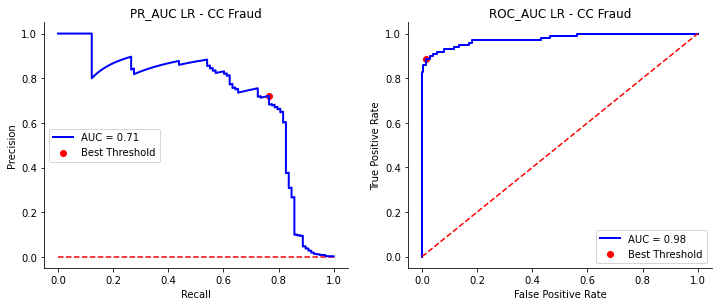

In [26]:
# plot Results Source

fig  = plt.subplots(figsize=(10, 4))
plt.tight_layout()

plt.subplot(1, 2, 1) # 2 rows , 2 col , index 1

# optimal f1_score threshold location on plot
fscore_lr = (2 * lr_results.pr_precision * lr_results.pr_recall) / (lr_results.pr_precision + lr_results.pr_recall)
ix_f_lr = np.argmax(fscore_lr)

# plot the precision-recall curves
no_skill = len(labels_test[labels_test==1]) / len(labels_test)
plt.plot([0, 1], [no_skill, no_skill], 'r--')
plt.plot(lr_results.pr_recall, lr_results.pr_precision, 'b', label = 'AUC = %0.2f' % lr_results.pr_auc, linewidth=2)
plt.scatter(lr_results.pr_recall[ix_f_lr], lr_results.pr_precision[ix_f_lr], marker='o', color='red', label='Best Threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("PR_AUC LR - CC Fraud")
plt.legend(loc = 6)
plt.gca().spines["top"].set_alpha(0.0); plt.gca().spines["right"].set_alpha(0.0);

plt.subplot(1, 2, 2)

# optimal G-Mean threshold location on plot
j_lr = lr_results.tpr - lr_results.fpr
ix_j_lr = np.argmax(j_lr)

plt.plot(lr_results.fpr, lr_results.tpr, 'b', label = 'AUC = %0.2f' % lr_results.roc_auc, linewidth=2)
plt.plot([0,1], [0,1], 'r--')
plt.scatter(lr_results.fpr[ix_j_lr], lr_results.tpr[ix_j_lr], marker='o', color='red', label='Best Threshold')
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC_AUC LR - CC Fraud")
plt.gca().spines["top"].set_alpha(0.0); plt.gca().spines["right"].set_alpha(0.0);

The red dots correspond to threshold location of optimal performance measure that maximizes AUC. f1_score is used as the performance measure for PR_Curve while Geometric mean is chosen for ROC_Curve. The Geometric Mean or G-Mean is a metric for imbalanced classification that, if optimized, will seek a balance between the true positive rate (tpr) and the false positive rate (fpr). G-Mean = sqrt(tpr * fpr) or (tpr - fpr) for faster calculation according to [Youden’s J statistic](https://en.wikipedia.org/wiki/Youden%27s_J_statistic)

Each point on these curves corresponds to a different classification threshold and a separate confusion matrix. So by specifying the confusion matrix you want, via choosing your classifier threshold implies some sort of cost weighting scheme. Then you just have to choose the confusion matrix that would imply the cost matrix you are looking for.

You might want to test more threshold apart from those on the curves, Regardless of the threshold you will test and for this approach to work properly, you’ll need to get the costs associated with each type of misclassification error, and you’ll need to make sure that the percentages of positive cases and negative cases match those the model will see at deployment.

If we are interested in a threshold that results in the best balance of precision and recall, then this is the same as optimizing the F-measure that summarizes the harmonic mean of both measures. Selecting threshold that maximize f1 score is not always the best choice cost wise, also that best balance between precision and recall sometimes is not required as the cost of low recall outweigh that of low precision

Summary:
- Thresholds at optimal values that maximize AUC might not be effective cost wise
- Estimating cost of different classification threshold will help us decide which confusion matrix provides best overall model.

<li><a href="#toc">Table of contents</a></li>

<a id='tm'></a>
### Threshold Moving Logistic Regression - Credit Card fraud

In [27]:
# Best classification threshold that maximize f1 score
lr_results.pr_thresh[ix_f_lr].round(2)

0.09

In [28]:
# Assessment of prediction results - Calculating cost at different decision threshold (threshold-moving)

# choosing a cut-off threshold
cutoff = [lr_results.pr_thresh[ix_f_lr - 5], lr_results.pr_thresh[ix_f_lr], lr_results.pr_thresh[ix_f_lr + 5]]
misclss_err = []

for c in cutoff:
    y_pred_classes = np.zeros_like(lr_results.pred_p)             # initialize a matrix full with zeros
    y_pred_classes[np.array(lr_results.pred_p) > c] = 1           # add a 1 if the cutoff was breached
    pr_precision, pr_recall, _ = precision_recall_curve(labels_test, y_pred_classes)
    pr_f1, pr_auc = f1_score(labels_test, y_pred_classes), auc(pr_recall, pr_precision)
    fpr, tpr, thresholds = roc_curve(labels_test, y_pred_classes)
    roc_auc = auc(fpr, tpr)
    tn, fp, fn, tp = confusion_matrix(labels_test, y_pred_classes).ravel()
    err_rate = (fp+fn) / len(y_pred_classes)
    misclss_err.append((tn, fp, fn, tp, err_rate.round(4), pr_precision[1].round(2), pr_recall[1].round(2), pr_f1.round(2), pr_auc.round(2), roc_auc.round(2),
                                  c.round(5) , y_pred_classes))

misclss_err_df = pd.DataFrame([i[0:11] for i in misclss_err], columns=['tn', 'fp', 'fn', 'tp', 'err_rate', 'fraud_precision', 'fraud_recall', 
                                                                                                        'f1-score', 'pr_auc', 'roc_auc', 'threshold'])    

# assuming different cost values for tp / fn

misclss_err_df['fp_cost'], misclss_err_df['fn_cost'] = misclss_err_df.fp * 10, misclss_err_df.fn * 100
misclss_err_df['total_misclss_cost'] = misclss_err_df.fp_cost + misclss_err_df.fn_cost

misclss_err_df

,tn,fp,fn,tp,err_rate,fraud_precision,fraud_recall,f1-score,pr_auc,roc_auc,threshold,fp_cost,fn_cost,total_misclss_cost
0,56831,33,23,75,0.0010,0.69,0.77,0.73,0.73,0.88,0.07076,330,2300,2630
1,56835,29,24,74,0.0009,0.72,0.76,0.74,0.74,0.88,0.09151,290,2400,2690
2,56837,27,27,71,0.0009,0.72,0.72,0.72,0.72,0.86,0.11364,270,2700,2970


We have made assessment of three different thresholds, including the one that maximize PR_AUC. Logistic regression predictions are re-assessed using the same approach discussed above at each of these thresholds; results are then displayed for comparison. The costs associated with these thresholds are hypothetical and are exaggerated for false negative instances compared to the costs of false positives ones; the main idea behind this is that the cost of undetected fraudulent transaction (false negative) outweigh those associated with false alarms (false positives)

2nd row represents the model performance at the threshold that maximize PR_AUC, indeed it resulted in an improvement in the AUC and f1 score statistics compared to original prediction (.74 vs. .71 for PR_AUC and .74 vs. .68 for f1 score); however, it is not the best at minimizing the overall misclassification cost or maximizing fraud recall over precision. Despite the improvement in fraud recall at all the three thresholds than initial prediction results (57%) the first threshold in the table gives better result and may be considered at deployment.

The misclassification error changes when the thresholds are changed. same as with other statistics the best value for the threshold may not be the one that minimizes the misclassification error as we can see that the first threshold has *somewhat* higher error rate but performs as we would expect it to perform.

Summary:
- Associated costs of different confusion matrix need to be accounted for when assessing model performance
- Sometimes having high recall on +ve class outweigh any other performance measure.
- There are many techniques that may be used to address an imbalanced classification problem; perhaps the simplest approach is to change the decision threshold.

In [29]:
# Classification report and confusion matrix for selected threshold
# assuming we selected first model having highest fraud recall

print(classification_report(labels_test, [i[11] for i in misclss_err][1], target_names=['Not', 'Fraud']), '-'*40, '\n', 
       confusion_matrix(labels_test,  [i[11] for i in misclss_err][1]))

              precision    recall  f1-score   support

         Not       1.00      1.00      1.00     56864
       Fraud       0.72      0.76      0.74        98

    accuracy                           1.00     56962
   macro avg       0.86      0.88      0.87     56962
weighted avg       1.00      1.00      1.00     56962
 ---------------------------------------- 
 [[56835    29]
 [   24    74]]


Improved predictions for the +ve class are obtained just by threshold moving without optimizing the model itself

<li><a href="#toc">Table of contents</a></li>

<a id='pc'></a>
### Probability Calibration - Logistic regression Credit Card Fraud

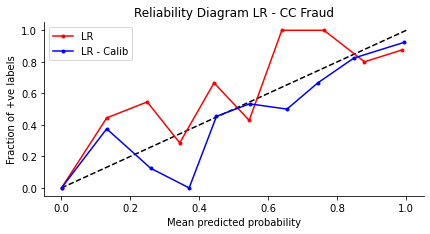

In [30]:
# LR Model calibration

calibrated = CalibratedClassifierCV(lr_results.model, method = 'isotonic', cv = 5)
calibrated.fit(features_train, labels_train)

# predict probabilities
probs = calibrated.predict_proba(features_test)[:, 1]

fig  = plt.subplots(figsize=(6, 3))
plt.tight_layout()

# reliability diagram - uncalibrated
fop_u, mpv_u = calibration_curve(labels_test, lr_results.pred_p, n_bins=10)

# reliability diagram - calibrated
fop_c, mpv_c = calibration_curve(labels_test, probs, n_bins=10, normalize=True)

# plot
plt.plot([0, 1], [0, 1], linestyle='--', color = 'black')
plt.plot(mpv_u, fop_u, marker='.', color = 'red', label = 'LR')
plt.plot(mpv_c, fop_c, marker='.', color = 'blue', label = 'LR - Calib')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of +ve labels')
plt.title("Reliability Diagram LR - CC Fraud")
plt.legend()
plt.gca().spines["top"].set_alpha(0.0); plt.gca().spines["right"].set_alpha(0.0);

In [31]:
# Classification report and confusion matrix for calibrated model

# class predictions rather than probability prediction
props_c = calibrated.predict(features_test)

print(classification_report(labels_test, props_c, target_names=['Not', 'Fraud']), '-'*40, '\n', 
       confusion_matrix(labels_test, props_c))

              precision    recall  f1-score   support

         Not       1.00      1.00      1.00     56864
       Fraud       0.75      0.71      0.73        98

    accuracy                           1.00     56962
   macro avg       0.88      0.86      0.87     56962
weighted avg       1.00      1.00      1.00     56962
 ---------------------------------------- 
 [[56841    23]
 [   28    70]]


Calibration of prediction probabilities is applied after the predictions have been made by a predictive model, it is a rescaling operation of prediction values so they better match the distribution observed in the training data.

There are two popular approaches to calibrating probabilities; they are the Platt Scaling/Sigmoid and Isotonic Regression. Platt Scaling (Logistic regression model to transform probabilities) is simpler and is suitable for reliability diagrams with the S-shape. Isotonic Regression (Weighted least-squares regression model to transform probabilities) is more complex, requires a lot more data (otherwise it may overfit), but can support reliability diagrams with different shapes. Overall, ‘isotonic’ will perform as well as or better than ‘sigmoid’ when there is enough data (greater than ~ 1000 samples) to avoid overfitting.

A reliability diagram is a line plot of the relative frequency of what was observed (y-axis) versus the predicted probability frequency (x-axis). Specifically, the predicted probabilities are divided up into a fixed number of buckets along the x-axis. The number of events (class=1) are then counted for each bin (e.g. the relative observed frequency). Finally, the counts are normalized. The results are then plotted as a line plot. Showing the number of samples of class 1 in each predicted probability bin.

It plots the true frequency of the positive label against its predicted probability, for binned predictions. The x axis represents the average predicted probability in each bin. The y axis is the fraction of positives, i.e. the proportion of samples whose class is the positive class (in each bin). For example, around 40% of prediction probability of 10% are related to class 1 and 80% of prediction probability of 100% are related to class 1.

Visually, reliability diagram suggests a better calibrated model when calibrated probabilities are hugging the diagonal line much better than uncalibrated model. The reliability curve of the calibrated model above is hugging the diagonal line better than the uncalibrated model, suggesting that calibration will affect prediction results for this model and this is evidenced in the printed confusion matrix; calibration resulted in higher recall than the original model's prediction before threshold moving (.71 vs. .57)

Uncalibrated LR is making a lot of predictions for class 1 at 10% prediction probability, so if this model is deployed and decision threshold for classification was set  >10% then the classifier will produce more predictions that are false negatives than if the threshold was < 10%. This can be noted in the previous example, LR predictions before threshold moving were based on 50% classification threshold this produced a total false negative of 42 instances; after moving classification threshold to 0.09 the false negative dropped to 24 instances marking a decrease of 43% from initial predictions. 


Summary:
- Probability calibration may result in better performance of un-tuned model even before threshold moving.
- Reliability diagram can be used to understand model behavior for selecting optimal classification threshold

In [32]:
# LR - Threshold moving after probability calibration

misclss_err = []

y_pred_classes = np.zeros_like(probs)                                                      # initialize a matrix full with zeros
y_pred_classes[np.array(probs) > lr_results.pr_thresh[ix_f_lr]] = 1           # add a 1 if the cutoff was breached
pr_precision, pr_recall, _ = precision_recall_curve(labels_test, y_pred_classes)
pr_f1, pr_auc = f1_score(labels_test, y_pred_classes), auc(pr_recall, pr_precision)
fpr, tpr, thresholds = roc_curve(labels_test, y_pred_classes)
roc_auc = auc(fpr, tpr)
tn, fp, fn, tp = confusion_matrix(labels_test, y_pred_classes).ravel()
err_rate = (fp+fn) / len(y_pred_classes)
misclss_err.append((tn, fp, fn, tp, err_rate.round(4), pr_precision[1].round(2), pr_recall[1].round(2), pr_f1.round(2), pr_auc.round(2), roc_auc.round(2),
                              lr_results.pr_thresh[ix_f_lr].round(5) , y_pred_classes))

misclss_err_df = pd.DataFrame([i[0:11] for i in misclss_err], columns=['tn', 'fp', 'fn', 'tp', 'err_rate', 'fraud_precision', 'fraud_recall', 
                                                                                                        'f1-score', 'pr_auc', 'roc_auc', 'threshold'])    

# assuming different cost values for tp / fn
misclss_err_df['fp_cost'], misclss_err_df['fn_cost'] = misclss_err_df.fp * 10, misclss_err_df.fn * 100
misclss_err_df['total_misclss_cost'] = misclss_err_df.fp_cost + misclss_err_df.fn_cost

misclss_err_df

,tn,fp,fn,tp,err_rate,fraud_precision,fraud_recall,f1-score,pr_auc,roc_auc,threshold,fp_cost,fn_cost,total_misclss_cost
0,56820,44,18,80,0.0011,0.65,0.82,0.72,0.73,0.91,0.09151,440,1800,2240


In [33]:
# calculating brier score for both calibrated and uncalibrated model

print('LR:', brier_score_loss(labels_test, lr_results.pred_p).round(5), '/----/' * 2, 'Calibrated LR:' , brier_score_loss(labels_test, probs).round(5))

LR: 0.00078 /----//----/ Calibrated LR: 0.00072


I've used the optimal threshold of PR_AUC obtained earlier as a classification threshold for the calibrated LR and this resulted in higher fraud recall (82% vs. 76%) and overall lower artificial total misclassification cost than that obtained after threshold moving of original model

Note that some algorithms are fit in such a way that their predicted probabilities are already calibrated. Logistic regression is one of these algorithms and this can be noted from the lower brier score before and after calibration. However, imbalanced classification impose bias that needs to be accounted for, a bias in the training dataset, such as a skew in the class distribution, means that the model will naturally predict a higher probability for the majority class than the minority class on average. Thus, calibrating probabilities is desired in general when working with imbalanced datasets, even for models like logistic regression that predict well-calibrated probabilities when the class labels are balanced.

Summary:

- Calibration combined with threshold moving did provide better prediction results for the fraud detection problem using a basic model (not tuned) on a highly skewed class distribution.

<li><a href="#toc">Table of contents</a></li>

<a id='ci'></a>
### Addressing Class Imbalance

Resampling is one of the methods by which class imbalance can be addressed, there are several popular resampling techniques summarized as follows:
- RandomUnderSampling: Removing examples randomly from the majority class (-ve), until they are equal to the total samples in the minority class (+ve)
- RandomOverSampling: Randomly duplicate samples from the minority class until they are equal to the total samples of the majority class
- Synthetic Minority Oversampling Technique - SMOTE: Creating artificial new samples from the minority class
- Mixed over and under sampling: Combining both methods to produce new training dataset with adjusted class distribution 

If we make the assumption that training and testing sets come from the same distribution, then when the training is unbalanced, the testing set has a skewed distribution as well. By removing majority class instances (undersampling), the training set is artificially rebalanced. As a consequence, we obtain different distributions for the training and testing sets, violating the basic assumption in machine learning that the training and testing sets are drawn from the same underlying distribution.

The bias introduced by undersampling need to be corrected, to produce well calibrated probabilities. So, we can perform probability calibration same as we did before and assess how will this affect model predictions

In [34]:
# Combining under and over sampling

# Oversampling SMOTE
ovr_s = SMOTE(sampling_strategy = .2, random_state=42)
features_tr_os_s, labels_tr_os_s = ovr_s.fit_resample(features_train, labels_train)

# Oversampling Random
ovr_r = RandomOverSampler(sampling_strategy = .2, random_state=42)
features_tr_os_r, labels_tr_os_r = ovr_r.fit_resample(features_train, labels_train)

# Undersampling Random
rus = RandomUnderSampler(sampling_strategy = .3, random_state=42)
features_tr_us, labels_tr_us = rus.fit_resample(features_train, labels_train)

# Mixed over and under sampling SMOTE
rus_s = RandomUnderSampler(sampling_strategy = .3, random_state=42)
features_tr_us_s, labels_tr_us_s = rus_s.fit_resample(features_tr_os_s, labels_tr_os_s)

# Mixed over and under sampling Random
rus_r = RandomUnderSampler(sampling_strategy = .3, random_state=42)
features_tr_us_r, labels_tr_us_r = rus_r.fit_resample(features_tr_os_r, labels_tr_os_r)

print('Class distribution of training dataset: ',  '\n', '-' * 40, '\n', 'Original: ',  '\n'*2, labels_train.value_counts(normalize = True).round(3).to_string(),  
      '\n', '-' * 40, '\n', 'Over sampling SMOTE: ', '\n'*2, labels_tr_os_s.value_counts(normalize = True).round(2).to_string(), '\n', '-' * 40, '\n',
      'Over sampling Random: ', '\n'*2, labels_tr_os_r.value_counts(normalize = True).round(2).to_string(), '\n', '-' * 40, '\n',
      'Under sampling Random: ', '\n'*2, labels_tr_us.value_counts(normalize = True).round(2).to_string(), '\n', '-' * 40, '\n',
      'Mixed over and under sampling SMOTE: ', '\n'*2, labels_tr_us_s.value_counts(normalize = True).round(2).to_string(), '\n', '-' * 40, '\n',
      'Mixed over and under sampling Random: ', '\n'*2, labels_tr_us_r.value_counts(normalize = True).round(2).to_string())

Class distribution of training dataset:  
 ---------------------------------------- 
 Original:  

 0    0.998
1    0.002 
 ---------------------------------------- 
 Over sampling SMOTE:  

 0    0.83
1    0.17 
 ---------------------------------------- 
 Over sampling Random:  

 0    0.83
1    0.17 
 ---------------------------------------- 
 Under sampling Random:  

 0    0.77
1    0.23 
 ---------------------------------------- 
 Mixed over and under sampling SMOTE:  

 0    0.77
1    0.23 
 ---------------------------------------- 
 Mixed over and under sampling Random:  

 0    0.77
1    0.23


Changes to class distribution (resampling) should only be applied to the training dataset. The intent is to influence the fit of the models. The resampling is not applied to the test or holdout dataset used to evaluate the performance of a model.

In [35]:
# Train model on mixed sampling set, the undersampled after being oversampled 

# Build Model

reg_lr_us = linear_model.LogisticRegression(C = .2, penalty = 'l2', solver = 'liblinear', random_state = 45)

lr_us_results = train_eval(reg_lr_us, features_tr_us, labels_tr_us, features_test, labels_test)

lr_us_results.prints

coef_df_lr_us = pd.DataFrame(lr_us_results.model.coef_[0], index = features.columns, columns = ['coef_lr_us'])

coef_df_lr_us.T

training time: 0.01 m 
 ----------------------------------------
prediction time 0.001 m 
 ----------------------------------------
PR_AUC:  0.6751 
 ---------------------------------------- 
 F1 score:  0.2716 
 ---------------------------------------- 
 ROC_AUC:  0.9856 
 ---------------------------------------- 
               precision    recall  f1-score   support

         Not       1.00      0.99      1.00     56864
       Fraud       0.16      0.87      0.27        98

    accuracy                           0.99     56962
   macro avg       0.58      0.93      0.63     56962
weighted avg       1.00      0.99      0.99     56962
 ---------------------------------------- 
 [[56421   443]
 [   13    85]]


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
coef_lr_us,0.002477,-0.068203,-0.088508,0.595844,0.149452,-0.139085,-0.048511,-0.303538,-0.235018,-0.392751,...,0.04767,0.005962,0.162117,0.104341,-0.019692,0.082372,-0.08526,-0.268214,0.10972,0.461329


Resampling the training set using a mixed over and under sampling approach did result in better recall for the +ve class but at the expense of increased false positives. While high recall is desired for the fraud problem, increased costs associated with false positive need to be assessed carefully.

Samples in the dataset are collected over two days so if we decide to deploy the undersampled model as is and assuming that prediction results on new data will hold true as those we saw when testing, using our hypothetical cost estimates, total monthly cost of fraud would be equal to 87k as follows:

    - 20K (13 / 2 daily undetected fraud transactions * 100 cost per transaction * 30 days) for undetected fraud cases 
    - 67K (443 / 2 daily false alarm * 10 cost per alarm * 30 days) Investigating false positive cases, assuming we will investigate all alarms

While the total cost of **mitigated** fraud transactions is 128K (85 / 2 * 100 * 30), whether to push for higher recall or to accept current performance depends on the level of risk we are willing to accept for undetected fraud transactions. Note that the fraudulent transaction has already took place and it now lives inside the system, sometimes losses are not recoverable depending on nature of each transaction; the word mitigated here should not be taken literally.

Summary:

- It is important to ensure that the characteristics of data used to test the model is similar to those we expect the model to see at deployment so that results obtained from the test dataset are replicated to the new data the model will be working on, and hence our estimation of different costs associated with misclassification errors.

- Cost estimates should reflect level of risk we are willing to accept, it should not be confined only to the value of fraudulent transactions rather, risk such as loss of reputation, business, customers and so on should be considered as well.

- Knowledge of associated costs is really important as it can drastically affect our assessment of model performance and decision of which model to deploy

<li><a href="#toc">Table of contents</a></li>

<a id='enp'></a>
###  Regularization Path - ElasticNet 

We already discussed how penalized regression can be used as a feature selection method, we will explore here how this can be done using ElasticNet model that combines both L1 and L2 regularization.

Attributes Ordered by How Early They Enter the Model at different levels of alpha:  

 ['V3' 'V14' 'V17' 'V12' 'V7' 'V10' 'V1' 'V4' 'V16' 'V11' 'V2' 'V5' 'V9'
 'V18' 'V6' 'V21' 'V19' 'V8' 'V20' 'V27' 'V13' 'V24' 'V15' 'V28' 'V26'
 'V23' 'V25' 'V22'] 
 **************************************************************************************************** 
 Attributes having zero coef along alpha path:  

 [] 
 **************************************************************************************************** 

Attributes Ordered by Coef size at optimum alpha:  

      coef_enet
V17  -0.015946
V14  -0.013093
V12  -0.010818
V16  -0.009298
V10  -0.008261
V11   0.006289
V7   -0.006278
V18  -0.005506
V3   -0.005280
V4    0.003908 
 ****************************************************************************************************


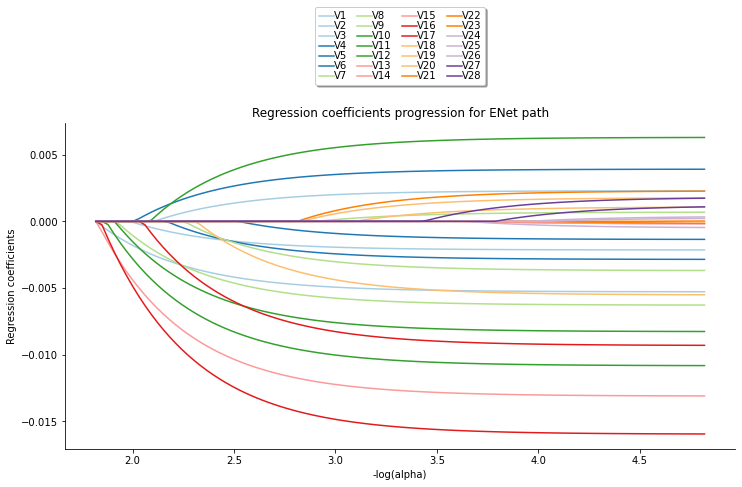

In [36]:
# train model on full data

alphas, coefs, _ = linear_model.enet_path(features, labels, l1_ratio = 0.8, return_models=False)

# Attribute order

# index of first non zero coef for each attribute
i = []

# obtain index of first non zero coef for each attribute

for j in coefs:
    if np.any(j != 0):
        _ = [i for i, val in enumerate(j) if val != 0]
        i.append(_[0])
    else:
        # will send 0 coef to end of list
        i.append(max(_))
    
# sort features columns by the order of thier non zero coef
print("Attributes Ordered by How Early They Enter the Model at different levels of alpha: ",  '\n'*2, features.columns[sorted(range(len(i)), 
                                                                                                                                            key = lambda k: i[k])].values, '\n', '*'*100, '\n', 
         "Attributes having zero coef along alpha path: ",  '\n'*2, features.columns[[i for i, x in enumerate(i) if x == max(_)]].values, '\n', '*'*100, '\n',)

# plot results

fig  = plt.subplots(figsize=(12, 6))

# plot coefficient progression for normalized model
# where x are the coef and y are the alpha
m_log_alphas = -np.log10(alphas)

n_lines = features.shape[1]

# select colormap
colormap = plt.cm.Paired

plt.gca().set_prop_cycle(plt.cycler('color', colormap(np.linspace(0, 0.8, n_lines))))

_ = plt.plot(m_log_alphas, coefs.T)

plt.ylabel("Regression coefficients")
plt.xlabel("-log(alpha)")
plt.title('Regression coefficients progression for ENet path')
plt.legend(features.columns, ncol=4, loc=8,  bbox_to_anchor=[0.5, 1.1],  columnspacing=1.0, labelspacing=0.0, handletextpad=0.0, handlelength=1.5,
                fancybox=True, shadow=True)
plt.gca().spines["top"].set_alpha(0.0); plt.gca().spines["right"].set_alpha(0.0);

# Coef size at best alpha

coef_df_enet = pd.DataFrame(coefs[:, -1:], index = features.columns, columns = ['coef_enet'])

# print("Best Coefficient Values at optimum alpha: ", '\n'*2, coef_df_enet.T, '\n', '*'*100)

print("Attributes Ordered by Coef size at optimum alpha: ", '\n'*2,  coef_df_enet[coef_df_enet.coef_enet != 0].sort_values('coef_enet', key=lambda x: abs(x),
                                                                                                                    ascending =False)[:10], '\n', '*'*100)

We've used Enet path model to visualize regularization path along different values of alpha and understand how coef evolve. We've then sorted attributes once by how early they enter the model and another by coef size; the former is an indication of correlation between attributes and class while the latter is an indication of feature importance obtained along the regularization path.

The main output of a Enet path model are the alphas and the coef path, alphas helps in eliminating guessing of values to be used as a regularization control parameter and coef path indicate the importance of each attribute given how the coef evolve along the path.

Looking at the start of the regularization path at 0 point on the y-axis, we will focus on three main lines, these are the lines related to attributes that are first to enter the model being V3 (light blue), V17(dark red) and V14 (light red). Going back to the correlation matrix we can notice that these three are indeed the highest correlated attributes, however, they are not equally as good in class discrimination. V17 and V14 do a better job at separating classes than V3, this was well noted form the histogram and scatter plots and is reflected in the coef behavior along the regularization path above. Despite that V3 had an early entry in the model (being highly correlated with the Class) its coef shrunk along the path as more attributes were added to the model, unlike V17 and V14 that had a steady increase noted from their wider curves. This confirms earlier note that correlation does not imply causation; just because an attribute is highly correlated with the dependent variable there is no guarantee that it will have a significant effect on model predictions

Some degree of agreement exists between the two methods of sorting attributes, but they don’t agree completely. For example, the variables V17, V14, V12, and V10 appear relatively high in both lists, unlike V3 that appears at the top of the first list (entering path) and moves down in the sorted list of coef sizes.

Summary:
- Correlation does not imply causation; just because an attribute is highly correlated with the Class we cannot assume that it is significant to model predictions
- Regularization path offers an overview on attribute(s) behavior which can be helpful in feature selection

In [37]:
# comparing coefs across models

coef_com_df = pd.concat([coef_df_lr, coef_df_lr_us, coef_df_enet], axis =1)

coef_com_df.style.bar(color='#999', align='zero')

,coef_lr,coef_lr_us,coef_enet
V1,0.042067,0.002477,-0.002146
V2,-0.057002,-0.068203,0.002291
V3,0.001914,-0.088508,-0.005280
V4,0.647326,0.595844,0.003908
V5,0.037358,0.149452,-0.002851
V6,-0.073103,-0.139085,-0.001354
V7,-0.026171,-0.048511,-0.006278
V8,-0.204282,-0.303538,0.000683
V9,-0.275215,-0.235018,-0.003684
V10,-0.715902,-0.392751,-0.008261


The models are consistent at saying that V10 is not as important as V14 in the mix of coef used, note how v17 and v14 stands out in the mix of coef used, and how v22 shrink for LR after resampling bias was introduced.

We can observe the effect of resampling on coef size, and how features that has stronger class discrimination power remained among the mix of highest coef while those that have less power had their coef size reduced.

**Summary:**

We’ve gone through several steps of model building, linked visual observations to model behavior and explored how can we evaluate a model using different metrics combined with overall cost estimates of different classification threshold. We've also understood the problem of imbalanced classification and how can it be addressed using resampling and threshold moving techniques; probability calibration was also discussed and the effect on predictions was illustrated using an already well calibrated model just to demonstrate that it can lead to better prediction performance for unbalanced classification problem.

Next we are going to explore Ensemble methods and how they are different than linear models when it comes to predictions

<li><a href="#toc">Table of contents</a></li>

<a id='ens'></a>
### Ensemble Methods:

- Ensemble methods employ a hierarchy of two algorithms. The low-level algorithm is called a base learner. The base learner is a single machine learning algorithm that gets used for all of the models that will get aggregated into an ensemble. The upper-level algorithm manipulates the inputs to the base learners so that the models they generate are somewhat independent. There are several upper-level algorithms that are widely used, I'll be focusing on two of them here that use DecisionTrees as a base learners.


- Think of Ensembles as a series of different models assembled into a single powerful model. How are models assembled and trained differs from one Ensemble model to another, this is what we will try to understand next

 
**Random Forest**


- Random forests generate its sequence of models by training them on subsets of the data using decision trees as base learners. The subsets are drawn at random from the full training set. The first model is the first tree. The second model is the average of the first two trees. The third model is the average of the first three trees, etc.


- One way in which the subset is selected is to randomly sample rows with replacement (bootstrap). The other random element is that the training sets for the individual trees in the random forests ensemble don’t incorporate all the attributes but take a random subset of the attributes also. So each tree will be trained on different training set and using different combination of features used in previous trees.

    
[**Gradient Boosting**](https://www.youtube.com/watch?v=3CC4N4z3GJc)


- Just like RandomForest ,GradientBoosting develops an ensemble of tree-based models but rather than training each of the trees in the ensemble on different subset of attributes and samples it trains each new tree on prediction errors(residuals) of earlier trees.


- To build intuition, we can think of a typical iteration towards solution as follows (this structure applies to both Regression and Classification; differences are in how prediction and residuals are calculated):

    - Make an initial prediction of the dependent value, for regression this can be the average of the dependent values while for classification this can be the log(odds) of class labels. Let’s call it pred_1
    - Calculate residuals, actual - initial prediction. Name it res_1
    - Train (fit) a new tree using the res_1 as dependent variable instead of the actual dependent variable and make predictions of res_1. Name it pred_2
    - Add pred_1 and scaled values of pred_2 together and let’s call it scaled_pred_2. Scaling is done using a fixed value, for example 0.1
    - Calculate res_2 using scaled_pred_2.That is actual - scaled_pred_2
    - Train (fit) a new tree using res_2 as training dependent variable to make predictions of res_2. We have now pred_3
    - Add pred_1 and scaled values of scaled_pred_2 and pred_3. scaled_pred_3 is born now.
    - Train a new tree and repeat.


- We can summarize the above iteration in the following three points:
    - An initial prediction is made then residuals are calculated. 
    - Subsequent Trees are trained using the residuals of previous trees instead of actual values/labels. 
    - The predicted values of each tree are partially added to the initial prediction until the specified number of trees are reached or residuals do not improve by additional trees.


- Example of Regression GB iteration fitting 2 trees

    - Data:

            Height | Color | Gender | Weight
                1.6    Blue       Male       88
                1.6    Green    Female   76
                1.5    Green    Female   56
                1.4    Green    Female   58
                1.8    Red        Male       77

    - Initial prediction, average of Weight values = (88+76+56+58+77) / 5 = 71. This is pred_1

    - Calculate residuals (aka Pseudo Residual) being actual weight values - average. This is res_1

            Height | Color | Gender | Weight | pred_1 | res_1
                1.6    Blue       Male        88          71         17       
                1.6    Green    Female    76          71          5
                1.5    Green    Female    56          71        -15
                1.4    Green    Female    60          71        -13
                1.8    Red        Male        77          71          6

    - Train (fit) a tree using res_1 instead of actual weights, and then predict res_1. This is pred_2 

                        Gender = F
                                  |
                Yes -------------------No
                      |                       |
               Height < 1.6     Color not blue
                      |                       |
                -----------            -------------   
                |             |           |              |
             (-14)       (5)       (6)          (17)

    - We will discuss decision trees later but for now know that -14 represents the average residuals of the two data points ((-15 + -13 / 2))

    - Add pred_1 to scaled pred_2 for each data point. This is scaled_pred_2, example for first row scaled_pred_2 = 71 + (0.1* 17) = 72.7

    - Calculate residuals (aka Pseudo Residual) using scaled_pred_2. This is res_2, example for same data point = 88 - 73 = 15.3

            Height | Color | Gender | Weight | pred_1 | res_1 | scaled_pred_2 | res_2 
                1.6    Blue       Male        88          71         17            72.7             15.3
                1.6    Green    Female    76          71          5             71.5              4.5
                1.5    Green    Female    56          71        -15            69.6            -13.6 
                1.4    Green    Female    60          71        -13            69.6            -11.6
                1.8    Red        Male        77          71          6             71.6              5.4

    - Train (fit) a new tree using res_2 instead of actual weights, and then predict res_2. This is pred_3 

                       Gender = F
                               |
                Yes -------------------No
                       |                       |
                Height < 1.6     Color not blue
                       |                       |
                -----------           -------------   
                |             |         |                |
            (-12.6)    (5.4)    (4.5)       (15.3)

    - Add pred_1 and scaled values of pred_2 and pred_3 for each data point. This is scaled_pred_3, calculate res_3 and repeat.

    - Residuals and predictions after fitting 2nd tree will look like this

            Height | Color | Gender | Weight | pred_1 | res_1 | scaled_pred_2 | res_2 | scaled_pred_3 | res_3
                1.6    Blue       Male        88          71         17              72.7           15.3            74.2           13.8
                1.6    Green    Female    76          71          5               71.5            4.5              72                4
                1.5    Green    Female    56          71        -15              69.6          -13.6            68.3          -12.3
                1.4    Green    Female    60          71        -13              69.6          -11.6            68.3          -10.3
                1.8    Red        Male        77          71          6               71.6            5.4              72.1            4.9

    - Two main things to note from the above table

        - Predictions are improving towards the correct actual value
        - residuals (errors) are shrinking


- We can think of GB as an optimization of the initial prediction by learning from previous errors hence the name boosting; as residuals are slowly being reduced at each iteration taking small steps towards the correct predictions hence the name Gradient.


- The value multiplied by residuals at each iteration (0.1) is called Learning rate(step size) and is introduced to control each tree's contribution to the model in order to prevent overfit, it scales a given tree prediction by a small factor that result in a small step in the right direction(minimizing errors).


- If the steps are too large (using high value of learning rate) the optimization can diverge instead of converging (converge means that as the iterations proceed, the output gets closer and closer to optimal solution). If the step size is too small, the process can take too many iterations, thus making the algorithm computationally expensive.

<li><a href="#toc">Table of contents</a></li>

<a id='rf'></a>
### RandomForestClassifier - Credit Card Fraud

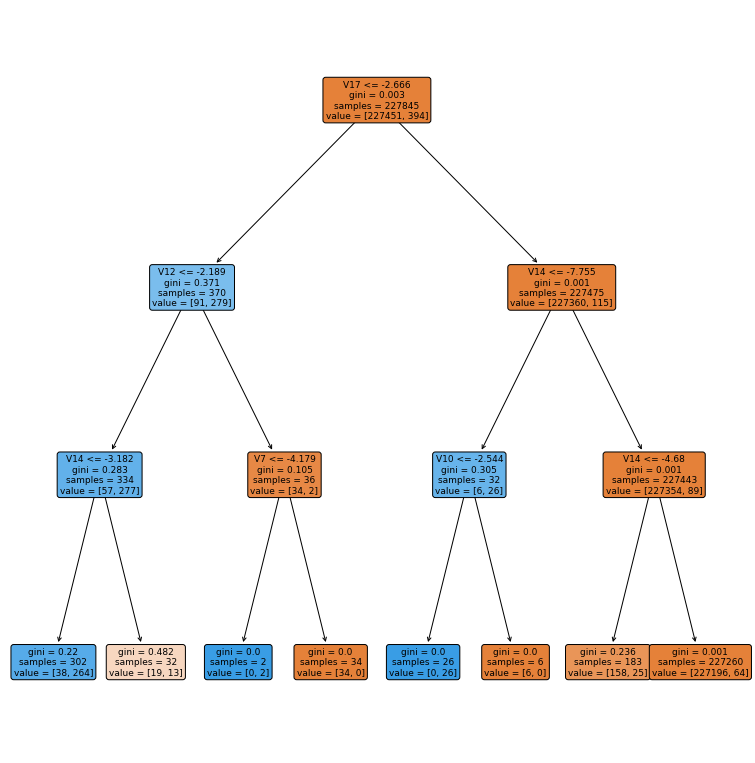

In [38]:
# Sample of a decision Tree - Credit Card Fraud

# Build model

fraud_tree = tree.DecisionTreeClassifier(max_depth = 3)
fraud_tree.fit(features_train, labels_train)

fig  = plt.subplots(figsize=(11, 11))
plt.tight_layout()

tree.plot_tree(fraud_tree, filled=True, rounded=True, feature_names = features.columns, fontsize=9);

In [39]:
# Training sample size and class distribution
labels_train.value_counts()

0    227451
1       394
Name: Class, dtype: int64

Decision tree classifiers cast a series of yes/no questions accordingly classification routes are determined, the depth of tree indicates the number of decisions that have to be made down the longest path through the tree. Important features for decision making are split on early (or near the top of the tree), that’s why V17 is being used as first decision split point.

Boxes are called nodes; there are two types of nodes: 1) Split nodes that pose yes/no question and leads to further splitting; the very first split node is called root node. 2) Terminal nodes that assign a prediction to examples that end up in them, they are often referred to as leaf nodes. In the plot above, the terminal nodes are the nodes at the bottom of the figure that have no branches or further decision nodes below them.

Each arrow represents an answer to the posed question, arrows to the left hand side (right side of the box pointing to V12) are the 'True' answer to the condition within the box; opposite arrows are the 'No' answer.

Colors indicate class membership, where brown colors are for -ve class nodes while blue represents +ve class. The intensity of coloring follows class concentration within each box, the higher the number of samples the darker the color.

Each box has 4 lines as follows:
- Split criteria, first split is done at V17 <= - 2.66
-  Measure of split quality based on [Gini](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity) and [Entropy](https://en.wikipedia.org/wiki/Decision_tree_learning#Information_gain) criteria. The choice does not make a lot of difference in performance.
- Total sample size
- Class distribution per node, first node holds all samples and same class distribution as seen the training set since no decision is being made.

How Predictions are made?
- An observation or row is passed to a non-terminal node, a decision is made then passed to left or right nodes to repeat the process until predictions are made.
- In above example, Tree selected V17 as first decision split point (root node), then depending on outcome multiple decisions are made until reaching terminal nodes (bottom of the graph) where value represent predictions.
- Terminal nodes hold the classification decision of each decision path/route; a pure node is the one holding single class only.

In [40]:
# RF build and evaluate - original training set

clf_rf = RandomForestClassifier(random_state = 45)

rf_results = train_eval(clf_rf, features_train, labels_train, features_test, labels_test)

rf_results.prints

training time: 23.03 m 
 ----------------------------------------
prediction time 0.131 m 
 ----------------------------------------
PR_AUC:  0.8299 
 ---------------------------------------- 
 F1 score:  0.8182 
 ---------------------------------------- 
 ROC_AUC:  0.9473 
 ---------------------------------------- 
               precision    recall  f1-score   support

         Not       1.00      1.00      1.00     56864
       Fraud       0.92      0.73      0.82        98

    accuracy                           1.00     56962
   macro avg       0.96      0.87      0.91     56962
weighted avg       1.00      1.00      1.00     56962
 ---------------------------------------- 
 [[56858     6]
 [   26    72]]


RandomForest (RF) produced better results right out of the box. We are concerned with reducing false negative predictions (26 instances) and RF did just that, compared to the 42 false negative instances from logistic regression. f1 score is better than LR (82 vs. 74); however, training time is considerably higher than that of linear model. And as the forest grows in numbers (n_estimators) and depth training time will also increase.

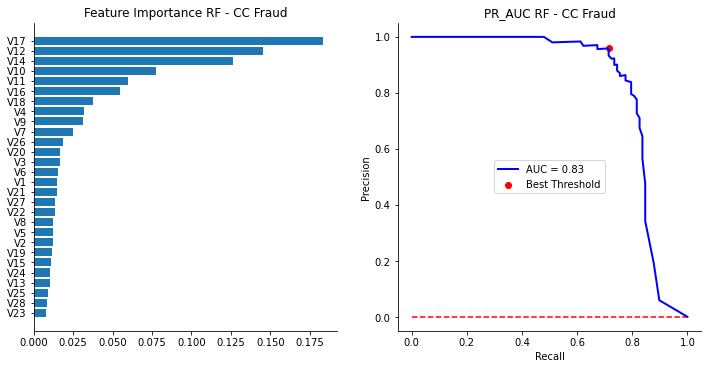

In [41]:
# Plot Results

fig  = plt.subplots(figsize=(10, 10))
plt.tight_layout()

plt.subplot(2, 2, 1)

feature_importance = rf_results.model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(features.columns)[sorted_idx])
plt.title("Feature Importance RF - CC Fraud")
plt.gca().spines["top"].set_alpha(0.0); plt.gca().spines["right"].set_alpha(0.0);

plt.subplot(2, 2, 2)

fscore_rf = (2 * rf_results.pr_precision * rf_results.pr_recall) / (rf_results.pr_precision + rf_results.pr_recall)
ix_f_rf = np.argmax(fscore_rf)

# plot the precision-recall curves
no_skill = len(labels_test[labels_test==1]) / len(labels_test)
plt.plot([0, 1], [no_skill, no_skill], 'r--')
plt.plot(rf_results.pr_recall, rf_results.pr_precision, 'b', label = 'AUC = %0.2f' % rf_results.pr_auc, linewidth=2)
plt.scatter(rf_results.pr_recall[ix_f_rf], rf_results.pr_precision[ix_f_rf], marker='o', color='red', label='Best Threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("PR_AUC RF - CC Fraud")
plt.legend(loc = 10)
plt.gca().spines["top"].set_alpha(0.0); plt.gca().spines["right"].set_alpha(0.0);

We can observe that RF is smart, making use of features that we identified earlier as good class discriminating features. The order of attributes is also similar to that produced by enet model although not identical.

In [42]:
# RF build and evaluate- resampled training set

clf_rf_us = RandomForestClassifier(n_estimators = 300, max_depth = 3, max_leaf_nodes = 6, max_features = 3, random_state = 45)

rf_results_us = train_eval(clf_rf_us, features_tr_us, labels_tr_us, features_test, labels_test)

rf_results_us.prints

training time: 0.12 m 
 ----------------------------------------
prediction time 0.241 m 
 ----------------------------------------
PR_AUC:  0.6271 
 ---------------------------------------- 
 F1 score:  0.7048 
 ---------------------------------------- 
 ROC_AUC:  0.9559 
 ---------------------------------------- 
               precision    recall  f1-score   support

         Not       1.00      1.00      1.00     56864
       Fraud       0.62      0.82      0.70        98

    accuracy                           1.00     56962
   macro avg       0.81      0.91      0.85     56962
weighted avg       1.00      1.00      1.00     56962
 ---------------------------------------- 
 [[56815    49]
 [   18    80]]


We've built a forest of 300 small trees (max depth of 3 and 6 nodes) while restricting the number of features used to decide split points to only 3.   


Comparing RF to LR results after using resampled training set would favor RF over LR. Assuming that prediction results on new data will hold true as those we saw when testing, using our hypothetical cost estimates, total monthly cost of fraud if RF classifier is deployed would be equal to 34k as follows:

- 27K (18 / 2 daily undetected fraud transactions * 100 cost per transaction * 30 days) for undetected fraud cases 
- 7K (49 / 2 daily false alarm * 10 cost per alarm * 30 days) Investigating false positive cases, assuming we will investigate all alarms

While the total cost of mitigated fraud transactions is 120K (80 / 2 * 100 * 30). RF did provide reduced fraud cost by minimizing false negative alarms but at the expense of reduced fraud recall and overall mitigated costs.

We should not forget that threshold moving after calibration of LR classifier did provide similar confusion matrix.

This demonstrate that while one metric may be important (fraud recall), focusing only on maximizing this metric and ignoring others (fraud precision) may not be optimal solution cost wise. It is better to maximize metric of choice while controlling others.

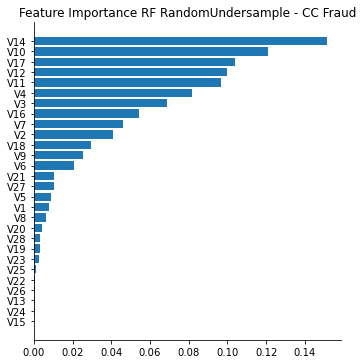

In [43]:
fig  = plt.subplots(figsize=(5, 5))
plt.tight_layout()

feature_importance = rf_results_us.model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(features.columns)[sorted_idx])
plt.title("Feature Importance RF RandomUndersample - CC Fraud")
plt.gca().spines["top"].set_alpha(0.0); plt.gca().spines["right"].set_alpha(0.0);

Resampling did change the order of feature importance compared to earlier predictions; however, both agree on using features having high discriminating power.

<li><a href="#toc">Table of contents</a></li>

<a id='gb'></a>
### GradientBoostingClassifier - Credit Card Fraud

In [44]:
# GB build and evaluate - original training set

clf_gb = GradientBoostingClassifier(random_state = 45)

gb_results = train_eval(clf_gb, features_train, labels_train, features_test, labels_test)

gb_results.prints

training time: 25.35 m 
 ----------------------------------------
prediction time 0.017 m 
 ----------------------------------------
PR_AUC:  0.646 
 ---------------------------------------- 
 F1 score:  0.7066 
 ---------------------------------------- 
 ROC_AUC:  0.7651 
 ---------------------------------------- 
               precision    recall  f1-score   support

         Not       1.00      1.00      1.00     56864
       Fraud       0.86      0.60      0.71        98

    accuracy                           1.00     56962
   macro avg       0.93      0.80      0.85     56962
weighted avg       1.00      1.00      1.00     56962
 ---------------------------------------- 
 [[56854    10]
 [   39    59]]


GB comes 2nd in best performance of un-tuned models followed by LR. However, training time is considerably higher than the other two models.

In [45]:
# GB build and evaluate - resampled training set

clf_gb_us = GradientBoostingClassifier(learning_rate = 0.001, n_estimators = 1000, subsample = .5, max_features = 5, max_depth = 5, 
                                                               random_state = 45)

gb_results_us = train_eval(clf_gb_us, features_tr_us, labels_tr_us, features_test, labels_test)

gb_results_us.prints

training time: 0.35 m 
 ----------------------------------------
prediction time 0.227 m 
 ----------------------------------------
PR_AUC:  0.7395 
 ---------------------------------------- 
 F1 score:  0.7364 
 ---------------------------------------- 
 ROC_AUC:  0.9709 
 ---------------------------------------- 
               precision    recall  f1-score   support

         Not       1.00      1.00      1.00     56864
       Fraud       0.66      0.83      0.74        98

    accuracy                           1.00     56962
   macro avg       0.83      0.91      0.87     56962
weighted avg       1.00      1.00      1.00     56962
 ---------------------------------------- 
 [[56823    41]
 [   17    81]]


GB using undersampled training provided better results over RF and calibrated LR, however, improvement is not significant. Very small steps are taken towards the solution (learning rate = 0.001); Number and size of trees are bigger than RF and that is reflected in the increased training and prediction time over RF using same training and test set.

<li><a href="#toc">Table of contents</a></li>

<a id='cr'></a>
**Conclusion:**

We've explored the inner working of some predictive models, used different metrics to assess their performance and evaluated costs associated with several imposed adjustments. We saw that our initial intuition and analysis of underlying data were replicated by the various models used, this is one aspect of using machine learning that is to confirm our understanding of the data regardless of whether we are going to build predictive model or not.

Un-tuned models may not result in optimal performance and using fixed train and test sets does not guarantee replicated model performance on new unseen data. We've done minor tuning and used fixed sets as we are exploring the behavior of different adjustments on model performance. A typical approach to model building for deployment would be:

- Feature selection
- Cross validating potential models
- Hyperparameter tuning, GridSearchCV combines tuning with subsequent validation.
- Train model on full data before deployment
- Deploy

The above are just broad lines, several other steps are also considered depending on the nature of the problem such as trying different resampling strategies, threshold moving, probability calibration and so on.

Feature engineering has a significant impact on model performance. This dataset has undergone a robust feature engineering process that resulted in some powerful features that can discriminate between classes.

Knowledge of costs associated with misclassification errors are really important to consider early on when building predictive model and optimizing performance as it provides guidance for reaching optimal solution to underlying problem. 

Penalized linear models are faster to train and can provide results comparable to those of ensembles.

**References:**

This is a minor listing of all the resources that I find really helpful and had significant impact on this project. All of them are invaluable, ordering does not imply favoritism except for StatQuest :D

- **https://statquest.org/**

- https://machinelearningmastery.com/

- https://stackexchange.com/

- https://www.statisticshowto.com/

- https://stats.libretexts.org/Bookshelves/Applied_Statistics

- https://stackoverflow.com/

- http://www.ulb.ac.be/di/map/adalpozz/pdf/Dalpozzolo2015PhD.pdf

- https://www3.nd.edu/~dial/publications/dalpozzolo2015calibrating.pdf

- https://thesai.org/Downloads/Volume11No6/Paper_60-A_Comparison_of_Data_Sampling_Techniques.pdf

- https://www.wiley.com/en-ie/Machine+Learning+in+Python%3A+Essential+Techniques+for+Predictive+Analysis-p-9781119183600

- https://www.udacity.com/course/intro-to-machine-learning--ud120

**Data Source:**

- https://data.world/vlad/credit-card-fraud-detection

<li><a href="#toc">Table of contents</a></li>